High Value Customer Identification (Insiders)

# 0.0 Solution Planning (IOT)

## Input 
1. Business Issue
    - Select the most valuable customers for a loyalty program.
2. Dataset
    - E-commerce sels online, during one year period.

## Output
1. Recommendation list of customers the should be in Loyalty program.
- List: client_id | is_insider

2. Report with business answers:
- 1. Who are eligible to participate the Insiders Program?
- 2. How many customers will be part of the group?
- 3. What are the mainly characteristics of there customers?
- 4. What is the % of revenue coming of these customers?
- 5. What's the revenue expectation for this group next month?
- 6. What are the conditions for someone to be eligible for insiders?
- 7. What are the conditions for someone to be removed from insiders?
- 8. What is the guarantee that the Insiders program is best than the remaining base?
- 9. What actions the marketing team can do for increasing the revenue?

## Tasks

1. Report with business answers:
- 1. Who are eligible to participate the Insiders Program?
    - What is being eligible? What are the most valuable customers?
        - Cost:
        - Buy Experience
        - Basket Size
        - High buy likely
        - Low devolution rate.
- 2. How many customers will be part of the group?
    - Total number of customers
    - % of Insiders Group
- 3. What are the mainly characteristics of there customers?
    - Write customers characteristics:
        - Age
        - Localization
    - Write consuming characteristics:
        - Clustering Features

- 4. What is the % of revenue coming of these customers?
    - Total Revenue vs Insiders Group Revenue
- 5. What's the revenue expectation for this group next month?
    - Insiders Group LTV
    - Cohort Analysis 

- 6. What are the conditions for someone to be eligible for insiders?
    - Define the Insiders update periodicity  
    - The customers needs to be lookalike someone of the Insiders group.


- 7. What are the conditions for someone to be removed from insiders?
    - Define the Insiders update periodicity  
    - The customers needs to be unlookalike someone of the Insiders group.   


- 8. What actions the marketing team can do for increasing the revenue?
    - Discount
    - New products
    - New employees

## Solutions Benchmark
1. Desk Research

## 0.1 Import libraries

In [1]:

import pickle
import glob
import gzip
import seaborn as sns
import os
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn import cluster as c 
from sklearn import metrics as m

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy as hc 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.cluster import SilhouetteVisualizer
from tqdm import tqdm
os.chdir("P:\Python\GitHub\insiders_clustering")



%matplotlib inline
plt.rcParams["figure.figsize"] = (15,8)

p:\Python\GitHub\insiders_clustering\dev_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip list --format=freeze > requirements_dev.txt

## 0.2 Load dataset

In [3]:
df0 = pd.read_csv('data/raw/data.csv', encoding='latin1')
df0.to_parquet('data/raw/data.parquet', index=False)
df0 = pd.read_parquet('data/raw/data.parquet')
df0.columns=df0.columns.str.lower()
df0.head(3)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


In [4]:
df0.T.head(1)

,0,1,2,3,4,5,6,7,8,9,...,541899,541900,541901,541902,541903,541904,541905,541906,541907,541908
invoiceno,536365,536365,536365,536365,536365,536365,536365,536366,536366,536367,...,581587,581587,581587,581587,581587,581587,581587,581587,581587,581587


# 1.0 Data Description

In [5]:
df1=df0.copy()

## 1.1 data dimensions

In [6]:
df1.shape

(541909, 8)

## 1.2 N/As

In [7]:
df1.isna().sum()/len(df1)

invoiceno      0.000000
stockcode      0.000000
description    0.002683
quantity       0.000000
invoicedate    0.000000
unitprice      0.000000
customerid     0.249267
country        0.000000
dtype: float64

## 1.3 data types

In [8]:
df1.dtypes

invoiceno       object
stockcode       object
description     object
quantity         int64
invoicedate     object
unitprice      float64
customerid     float64
country         object
dtype: object

## 1.4 descriptive statistics - numeric

In [9]:
num_attributes = df1.select_dtypes(include=['int64','float64','int32'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [10]:
pd.concat([num_attributes.describe(percentiles=[.5]).T,num_attributes.agg(['skew','kurtosis']).T],axis=1)

,count,mean,std,min,50%,max,skew,kurtosis
quantity,541909.0,9.552250,218.081158,-80995.00,3.00,80995.0,-0.264076,119769.160031
unitprice,541909.0,4.611114,96.759853,-11062.06,2.08,38970.0,186.506972,59005.719097
customerid,406829.0,15287.690570,1713.600303,12346.00,15152.00,18287.0,0.029835,-1.179982


### 1.4.1 negative quantity

In [11]:
#how many negative quantities there is?

aux0=num_attributes[num_attributes['quantity']<0]
print(aux0['quantity'].head(3))
print(f"There is {len(aux0)/len(num_attributes)} negative quantity")
# Because it has less than  2% of negative quantity, in this Crisp-DM circle all negatives prices will be dropped

141    -1
154    -1
235   -12
Name: quantity, dtype: int64
There is 0.019604767590130447 negative quantity


### 1.4.2 unit price

In [12]:
# inspect unitprice equal zero
aux0=num_attributes[num_attributes['unitprice']==0]
print(aux0['unitprice'].head(3))
print(f"There is {len(aux0)/len(num_attributes)} 0 quantity")

# Because it has less than  1% of negative unit price, in this Crisp-DM circle all negatives prices will be dropped

622     0.0
1970    0.0
1971    0.0
Name: unitprice, dtype: float64
There is 0.004641000610803659 0 quantity


# 2.0 Data Cleaning and Feature Filtering

## 2.1 Treat NAs

In [13]:
df2 = df1.copy()

In [14]:
df_missing = df2[df2['customerid'].isna()]
df_not_missing = df2[~df2['customerid'].isna()]
df_missing[df_missing['invoiceno'].isin(df_not_missing['invoiceno'])].shape

# create reference
df_backup = pd.DataFrame( df_missing['invoiceno'].drop_duplicates())
df_backup['customerid']=np.arange(80000, 80000+len( df_backup ), 1)

# merge original with reference df2farme
df2 = df2.merge(df_backup, on='invoiceno', how='left')

#coalesce
df2['customerid'] = df2['customerid_x'].combine_first( df2['customerid_y'])

#drop extra columns
df2 = df2.drop( columns=['customerid_x','customerid_y'], axis=1)

## 2.2 Data types treatment

In [15]:
df2['invoicedate'] = df2['invoicedate'].str.split(expand=True)[0]
df2['invoicedate'] = pd.to_datetime( df2['invoicedate'], format="%m/%d/%Y",errors='coerce')
df2['customerid']=df2['customerid'].astype(int)

## 2.3 keep only numbers of invoiceno

In [16]:
df2=df2[~df2['invoiceno'].str.contains('[^0-9]+', na=False)]

df2 = df2.drop( columns='description', axis=1 )

# 3.0 Feature Engineering

In [17]:
# data reference
df3=df2.copy()

## 3.1 Feature Creation

In [18]:
df_ref=df3[['customerid']].drop_duplicates(ignore_index=True)
print(df_ref.shape)
df_ref.head(3)

(7864, 1)


,customerid
0,17850
1,13047
2,12583


### 3.1.1 gross_revenue

In [19]:
# gross revenue
purchases = df3.loc[df3['quantity'] >= 0, :]
purchases['gross_revenue'] = purchases['quantity'] * purchases['unitprice']
df_monetary = purchases[['customerid', 'gross_revenue']].groupby( 'customerid').sum().reset_index()
df_ref=df_ref.merge(df_monetary,on='customerid',how='left').fillna(0)
df_ref.head(2)

C:\Users\kosmo\AppData\Local\Temp\ipykernel_16312\1042718411.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases['gross_revenue'] = purchases['quantity'] * purchases['unitprice']


,customerid,gross_revenue
0,17850,5391.21
1,13047,3237.54


### 3.1.2 quantity_return

In [20]:
# gross outgoings
returns = df3.loc[df3['quantity'] < 0, :]
returns['gross_returns'] = returns['quantity'] * returns['unitprice']*-1
df_returns = returns[['customerid', 'gross_returns']].groupby( 'customerid').sum().reset_index()
df_ref=df_ref.merge(df_returns,on='customerid',how='left').fillna(0)
df_ref.head()

C:\Users\kosmo\AppData\Local\Temp\ipykernel_16312\1030180716.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns['gross_returns'] = returns['quantity'] * returns['unitprice']*-1


,customerid,gross_revenue,gross_returns
0,17850,5391.21,0.0
1,13047,3237.54,0.0
2,12583,7281.38,0.0
3,13748,948.25,0.0
4,15100,876.00,0.0


In [21]:
#The gross return column has zeros, let's find out

In [22]:
returns = df3.loc[df3['quantity'] < 0, :]
returns.describe()

,quantity,invoicedate,unitprice,customerid
count,1336.000000,1336,1336.0,1336.000000
mean,-154.907934,2011-06-14 21:52:48.862275328,0.0,81892.139222
min,-9600.000000,2010-12-01 00:00:00,0.0,80013.000000
25%,-84.000000,2011-03-30 00:00:00,0.0,81080.750000
50%,-30.000000,2011-06-08 00:00:00,0.0,81830.500000
75%,-8.000000,2011-09-23 00:00:00,0.0,82816.500000
max,-1.000000,2011-12-08 00:00:00,0.0,83703.000000
std,588.292456,NaN,0.0,1038.864108


In [23]:
#The unit price column for returned itens is full of zero's, therefore let's use the feature "quantity_return" instead of "gross_returns"

In [24]:
df_ref = df_ref.loc[:, df_ref.columns != "gross_returns"]
returns = df3.loc[df3['quantity'] < 0, :]
returns['qtd_returns'] = returns['quantity']*-1
df_returns = returns[['customerid', 'qtd_returns']].groupby( 'customerid').sum().reset_index()
df_ref=df_ref.merge(df_returns,on='customerid',how='left').fillna(0)
df_ref.describe()

C:\Users\kosmo\AppData\Local\Temp\ipykernel_16312\2009242477.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns['qtd_returns'] = returns['quantity']*-1


,customerid,gross_revenue,qtd_returns
count,7864.000000,7864.000000,7864.000000
mean,45133.176501,1354.987600,26.317014
std,33133.615558,6829.073832,249.287498
min,12346.000000,0.000000,0.000000
25%,15040.500000,0.000000,0.000000
50%,17721.000000,324.160000,0.000000
75%,81633.000000,1158.422500,0.000000
max,83709.000000,280206.020000,9600.000000


### 3.1.3 recency

In [25]:
df_recency = purchases.groupby(['customerid', 'invoicedate']).sum()
df_recency.head()

invoiceno  \
customerid invoicedate                                                      
12346      2011-01-18                                              541431   
12347      2010-12-07   5376265376265376265376265376265376265376265376...   
           2011-01-26   5422375422375422375422375422375422375422375422...   
           2011-04-07   5492225492225492225492225492225492225492225492...   
           2011-06-09   5562015562015562015562015562015562015562015562...   

                                                                stockcode  \
customerid invoicedate                                                      
12346      2011-01-18                                               23166   
12347      2010-12-07   8511622375714772249222771227722277322774227752...   
           2011-01-26   84625A84625C8511620719223752237620966227252272...   
           2011-04-07   2237622374223712237520665230762179122550231772...   
           2011-06-09   2308423162231712317223170231732317423175223712...   

                        quantity  unitprice  \
customerid invoicedate                        
12346      2011-01-18      74215       1.04   
12347      2010-12-07        319      89.59   
           2011-01-26        315      73.17   
           2011-04-07        483      62.29   
           2011-06-09        196      53.62   

                                                                  country  \
customerid invoicedate                                                      
12346      2011-01-18                                      United Kingdom   
12347      2010-12-07   IcelandIcelandIcelandIcelandIcelandIcelandIcel...   
           2011-01-26   IcelandIcelandIcelandIcelandIcelandIcelandIcel...   
           2011-04-07   IcelandIcelandIcelandIcelandIcelandIcelandIcel...   
           2011-06-09   IcelandIcelandIcelandIcelandIcelandIcelandIcel...   

                        gross_revenue  
customerid invoicedate                 
12346      2011-01-18        77183.60  
12347      2010-12-07          711.79  
           2011-01-26          475.39  
           2011-04-07          636.25  
           2011-06-09          382.52

In [26]:
#recency
df_recency = purchases.groupby(['customerid', 'invoicedate']).max().reset_index()
print( df_recency.shape )
df_recency['recencydays'] = ( df3['invoicedate'].max() - df_recency['invoicedate'] ).dt.days
print( df_recency.shape )
df_recency= df_recency[['customerid','recencydays']].copy()
print( df_recency.shape )
df_ref=df_ref.merge(df_recency, how='left', on='customerid')


print(df_ref.isna().sum(), df_ref.shape)
df_ref = df_ref.drop_duplicates(subset='customerid', keep='last')
print(df_ref.shape)
df_ref.head()

(18955, 8)
(18955, 9)
(18955, 2)
customerid          0
gross_revenue       0
qtd_returns         0
recencydays      1336
dtype: int64 (20291, 4)
(7864, 4)


,customerid,gross_revenue,qtd_returns,recencydays
1,17850,5391.21,0.0,372.0
9,13047,3237.54,0.0,31.0
24,12583,7281.38,0.0,2.0
28,13748,948.25,0.0,95.0
31,15100,876.00,0.0,333.0


### 3.1.4 quantity of items kept

In [27]:
# quantity of products purchased
df_freq = purchases[['customerid', 'quantity']].drop_duplicates().groupby( 'customerid' ).sum().reset_index().rename( columns={'quantity':'qtd_items'})
df_ref = pd.merge( df_ref, df_freq, on='customerid', how='left' ).fillna(0)
print(df_ref.isna().sum(), df_ref.shape)

df_ref.head()


customerid       0
gross_revenue    0
qtd_returns      0
recencydays      0
qtd_items        0
dtype: int64 (7864, 5)


,customerid,gross_revenue,qtd_returns,recencydays,qtd_items
0,17850,5391.21,0.0,372.0,35.0
1,13047,3237.54,0.0,31.0,132.0
2,12583,7281.38,0.0,2.0,1569.0
3,13748,948.25,0.0,95.0,169.0
4,15100,876.00,0.0,333.0,48.0


### 3.1.5 avg ticket

In [28]:
 # Avg Ticket
df_ref['avg_ticket']=df_ref['gross_revenue']/(df_ref['qtd_items']-df_ref['qtd_returns'])
df_ref['avg_ticket']=df_ref['avg_ticket'].replace([np.inf, -np.inf], 0) 
print(df_ref.shape)
df_ref.isna().sum()

(7864, 6)


customerid       0
gross_revenue    0
qtd_returns      0
recencydays      0
qtd_items        0
avg_ticket       0
dtype: int64

### 3.1.6 frequency

In [29]:
# frequency

df_aux = ( df3[['customerid', 'invoiceno', 'invoicedate']].drop_duplicates()
                                                        .groupby('customerid')
                                                        .agg( max_ = ('invoicedate', 'max'),
                                                            min_= ('invoicedate', 'min'),
                                                            days_= ('invoicedate', lambda x: (( x.max() - x.min()).days ) +1 ),
                                                            buy_ = ('invoiceno', 'count')).reset_index()
)

df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

df_ref= df_ref.merge(df_aux[['customerid','frequency']], on='customerid', how='left')
print(df_ref.shape)
df_ref.isna().sum()

(7864, 7)


customerid       0
gross_revenue    0
qtd_returns      0
recencydays      0
qtd_items        0
avg_ticket       0
frequency        0
dtype: int64

### 3.1.7 nunique items

In [30]:
# basket size
df_aux = ( purchases.groupby('customerid').agg( n_purchases_unique = ('invoiceno','nunique'), n_products = ('quantity','sum'))
                                            .reset_index()
)

#calculation
df_ref = df_ref.merge( df_aux[['customerid', 'n_purchases_unique']].drop_duplicates(), how='left', on='customerid')

print(df_ref.isna().sum(), df_ref.shape)

df_ref.head()

customerid               0
gross_revenue            0
qtd_returns              0
recencydays              0
qtd_items                0
avg_ticket               0
frequency                0
n_purchases_unique    1336
dtype: int64 (7864, 8)


,customerid,gross_revenue,qtd_returns,recencydays,qtd_items,avg_ticket,frequency,n_purchases_unique
0,17850,5391.21,0.0,372.0,35.0,154.034571,17.000000,34.0
1,13047,3237.54,0.0,31.0,132.0,24.526818,0.029155,10.0
2,12583,7281.38,0.0,2.0,1569.0,4.640778,0.040323,15.0
3,13748,948.25,0.0,95.0,169.0,5.610947,0.017921,5.0
4,15100,876.00,0.0,333.0,48.0,18.250000,0.073171,3.0


## 3.2 Create Data Engineering Function

In [31]:
%%writefile src/features/build_features.py
import pandas as pd
import numpy as np



def build_features(data):

     # Create a DataFrame df_ref containing unique customer IDs from data
     df_ref = data[['customerid']].drop_duplicates(ignore_index=True)

     # Calculate gross revenue for each customer
     purchases = data.loc[data['quantity'] >= 0, :]
     purchases['gross_revenue'] = purchases['quantity'] * purchases['unitprice']
     df_monetary = purchases[['customerid', 'gross_revenue']].groupby('customerid').sum().reset_index()
     df_ref = df_ref.merge(df_monetary, on='customerid', how='left').fillna(0)

     # Calculate gross outgoings and quantity of returns for each customer
     returns = data.loc[data['quantity'] < 0, :]
     returns['gross_returns'] = returns['quantity'] * returns['unitprice'] * -1
     df_returns = returns[['customerid', 'gross_returns']].groupby('customerid').sum().reset_index()
     df_ref = df_ref.merge(df_returns, on='customerid', how='left').fillna(0)

     # Calculate the recency of purchases for each customer
     df_recency = purchases.groupby(['customerid', 'invoicedate']).max().reset_index()
     df_recency['recencydays'] = (data['invoicedate'].max() - df_recency['invoicedate']).dt.days
     df_recency = df_recency[['customerid', 'recencydays']].copy()
     df_ref = df_ref.merge(df_recency, how='left', on='customerid')
     df_ref = df_ref.drop_duplicates(subset='customerid', keep='last')

     # Calculate the quantity of products purchased for each customer
     df_freq = purchases[['customerid', 'quantity']].drop_duplicates().groupby('customerid').sum().reset_index().rename(columns={'quantity': 'qtd_items'})
     df_ref = pd.merge(df_ref, df_freq, on='customerid', how='left').fillna(0)

     # Calculate the frequency of purchases for each customer
     df_aux = (data[['customerid', 'invoiceno', 'invoicedate']].drop_duplicates()
               .groupby('customerid')
               .agg(max_=('invoicedate', 'max'),
                    min_=('invoicedate', 'min'),
                    days_=('invoicedate', lambda x: ((x.max() - x.min()).days) + 1),
                    buy_=('invoiceno', 'count')).reset_index()
               )
     df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)
     df_ref = df_ref.merge(df_aux[['customerid', 'frequency']], on='customerid', how='left')

     # Calculate the basket size for each customer
     df_aux = purchases.groupby('customerid').agg(n_purchases_unique=('invoiceno', 'nunique'), n_products=('quantity', 'sum')).reset_index()
     df_ref = df_ref.merge(df_aux[['customerid', 'n_purchases_unique']].drop_duplicates(), how='left', on='customerid')


     #qtd items returns
     df_ref = df_ref.loc[:, df_ref.columns != "gross_returns"]
     returns = data.loc[data['quantity'] < 0, :]
     returns['qtd_returns'] = returns['quantity']*-1
     df_returns = returns[['customerid', 'qtd_returns']].groupby( 'customerid').sum().reset_index()
     df_ref = df_ref.merge(df_returns,on='customerid',how='left').fillna(0)
     

     #avg ticket
     df_ref['avg_ticket']=df_ref['gross_revenue']/(df_ref['qtd_items']-df_ref['qtd_returns'])
     df_ref['avg_ticket']=df_ref['avg_ticket'].replace([np.inf, -np.inf], 0) 


     return df_ref

Overwriting src/features/build_features.py


# 4.0 Feature Selection

In [32]:
df4=df_ref.copy()
df4 = df4.drop_duplicates()
print( df_ref.shape, df4.shape)

(7864, 8) (7864, 8)


# 5.0 EDA (Exploratory Data Analysis)

In [33]:
df5=df4.copy()
df5.head()

,customerid,gross_revenue,qtd_returns,recencydays,qtd_items,avg_ticket,frequency,n_purchases_unique
0,17850,5391.21,0.0,372.0,35.0,154.034571,17.000000,34.0
1,13047,3237.54,0.0,31.0,132.0,24.526818,0.029155,10.0
2,12583,7281.38,0.0,2.0,1569.0,4.640778,0.040323,15.0
3,13748,948.25,0.0,95.0,169.0,5.610947,0.017921,5.0
4,15100,876.00,0.0,333.0,48.0,18.250000,0.073171,3.0


## 5.1 Univariate Analysis

In [34]:
num_attributes1 = df5.select_dtypes(include=['int64','float64','int32'])

In [35]:
a0=pd.concat([num_attributes1.describe(percentiles=[.5,.75]).T,num_attributes1.agg(['skew','kurtosis']).T],axis=1)
a0['max-0.75']=a0['max']-a0['75%']
a0['CV']=a0['std']/a0['mean']
a0

# NEGATIVE Tickets
# EXTREME Gross Revenue Value
# EXTREME qtd items values
# EXTREME qtd items return values
# EXTREME average ticket value and HIGH CV


,count,mean,std,min,50%,75%,max,skew,kurtosis,max-0.75,CV
customerid,7864.0,45133.176501,33133.615558,12346.00000,17721.000000,81633.0000,83709.00,0.205096,-1.950532,2076.0000,0.734130
gross_revenue,7864.0,1354.987600,6829.073832,0.00000,324.160000,1158.4225,280206.02,24.714885,803.904230,279047.5975,5.039953
qtd_returns,7864.0,26.317014,249.287498,0.00000,0.000000,0.0000,9600.00,25.420021,842.651716,9600.0000,9.472484
recencydays,7864.0,101.883774,112.555043,0.00000,52.000000,182.0000,373.00,0.953834,-0.396154,191.0000,1.104740
qtd_items,7864.0,202.683367,1495.934867,0.00000,60.000000,159.0000,80996.00,39.392946,1915.674451,80837.0000,7.380649
avg_ticket,7864.0,11.847148,173.111073,-0.00000,4.610646,9.9088,13541.33,64.608881,4822.979056,13531.4212,14.612046
frequency,7864.0,0.671036,0.512030,0.00545,1.000000,1.0000,17.00,3.851242,130.562558,16.0000,0.763044
n_purchases_unique,6528.0,3.174786,6.469023,1.00000,1.000000,3.0000,210.00,14.059215,345.222474,207.0000,2.037625


### inspect EXTREME qtd items

In [36]:
df5.sort_values('qtd_items', ascending=False).head()

,customerid,gross_revenue,qtd_returns,recencydays,qtd_items,avg_ticket,frequency,n_purchases_unique
4188,16446,168472.50,0.0,0.0,80996.0,2.080010,0.009709,2.0
1498,12346,77183.60,0.0,325.0,74215.0,1.040000,1.000000,1.0
463,17450,194550.79,0.0,8.0,38639.0,5.035089,0.127778,46.0
1917,16333,26626.80,0.0,7.0,21352.0,1.247040,0.072607,22.0
244,17949,58510.48,0.0,1.0,17376.0,3.367316,0.121294,45.0


In [37]:
df5[df5['customerid']==16446].head(10)
#this customer will be filtered out because it has a very extreme item buy quantity and extreme item returns

,customerid,gross_revenue,qtd_returns,recencydays,qtd_items,avg_ticket,frequency,n_purchases_unique
4188,16446,168472.5,0.0,0.0,80996.0,2.08001,0.009709,2.0


### inspect EXTREME gross revenue values

In [38]:
df5.sort_values('gross_revenue', ascending=False).head()

,customerid,gross_revenue,qtd_returns,recencydays,qtd_items,avg_ticket,frequency,n_purchases_unique
1083,14646,280206.02,0.0,1.0,15853.0,17.675268,0.209040,74.0
531,18102,259657.30,0.0,0.0,12872.0,20.172258,0.163043,60.0
463,17450,194550.79,0.0,8.0,38639.0,5.035089,0.127778,46.0
4188,16446,168472.50,0.0,0.0,80996.0,2.080010,0.009709,2.0
66,14911,143825.06,0.0,1.0,4247.0,33.865095,0.538874,201.0


In [39]:
#inspect higher profit customer
df1[df1['customerid']==18102].head(10)
# This customer just buys a lot :)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
16425,537657,82484,WOOD BLACK BOARD ANT WHITE FINISH,408,12/7/2010 16:42,4.78,18102.0,United Kingdom
16426,537657,22830,UTILTY CABINET WITH HOOKS,30,12/7/2010 16:42,19.84,18102.0,United Kingdom
16427,537657,22189,CREAM HEART CARD HOLDER,972,12/7/2010 16:42,2.31,18102.0,United Kingdom
16428,537657,22188,BLACK HEART CARD HOLDER,972,12/7/2010 16:42,2.31,18102.0,United Kingdom
16429,537657,21623,VINTAGE UNION JACK MEMOBOARD,408,12/7/2010 16:42,6.38,18102.0,United Kingdom
16430,537658,82484,WOOD BLACK BOARD ANT WHITE FINISH,48,12/7/2010 16:43,4.78,18102.0,United Kingdom
16431,537658,22189,CREAM HEART CARD HOLDER,36,12/7/2010 16:43,2.31,18102.0,United Kingdom
16432,537658,22188,BLACK HEART CARD HOLDER,36,12/7/2010 16:43,2.31,18102.0,United Kingdom
16433,537659,22765,NEWSPAPER STAND,23,12/7/2010 16:43,9.89,18102.0,United Kingdom
16434,537659,22507,MEMO BOARD RETROSPOT DESIGN,208,12/7/2010 16:43,3.86,18102.0,United Kingdom


### Inspect extreme qtd items return values


In [40]:
df5.sort_values('qtd_returns', ascending=False).head()

,customerid,gross_revenue,qtd_returns,recencydays,qtd_items,avg_ticket,frequency,n_purchases_unique
4661,81914,0.0,9600.0,0.0,0.0,-0.0,1.0,NaN
4662,81915,0.0,9600.0,0.0,0.0,-0.0,1.0,NaN
4660,81913,0.0,9058.0,0.0,0.0,-0.0,1.0,NaN
2617,80837,0.0,5368.0,0.0,0.0,-0.0,1.0,NaN
7033,83229,0.0,4830.0,0.0,0.0,-0.0,1.0,NaN


In [41]:
df1[df1['customerid']==16029] 
# This one just returns a lot

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
175,536386,84880,WHITE WIRE EGG HOLDER,36,12/1/2010 9:57,4.95,16029.0,United Kingdom
176,536386,85099C,JUMBO BAG BAROQUE BLACK WHITE,100,12/1/2010 9:57,1.65,16029.0,United Kingdom
177,536386,85099B,JUMBO BAG RED RETROSPOT,100,12/1/2010 9:57,1.65,16029.0,United Kingdom
178,536387,79321,CHILLI LIGHTS,192,12/1/2010 9:58,3.82,16029.0,United Kingdom
179,536387,22780,LIGHT GARLAND BUTTERFILES PINK,192,12/1/2010 9:58,3.37,16029.0,United Kingdom
...,...,...,...,...,...,...,...,...
431946,573774,22666,RECIPE BOX PANTRY YELLOW DESIGN,36,11/1/2011 10:27,2.55,16029.0,United Kingdom
431947,573774,23206,LUNCH BAG APPLE DESIGN,50,11/1/2011 10:27,1.45,16029.0,United Kingdom
431948,573774,22961,JAM MAKING SET PRINTED,96,11/1/2011 10:27,1.25,16029.0,United Kingdom
431949,573774,21931,JUMBO STORAGE BAG SUKI,100,11/1/2011 10:27,1.74,16029.0,United Kingdom


In [42]:
# These customers has only returns. It's not coherent to compare them with the others. This database didn't capture their previous purchase,
#therefore it's impossible to find out if the customers generate profit for the company (Bought more than delivered).

## Avg Ticket

In [43]:
df5.sort_values('avg_ticket',ascending=True)

,customerid,gross_revenue,qtd_returns,recencydays,qtd_items,avg_ticket,frequency,n_purchases_unique
6622,83011,0.00,40.0,0.0,0.0,-0.00,1.0,NaN
3418,81255,0.00,14.0,0.0,0.0,-0.00,1.0,NaN
3419,81256,0.00,0.0,245.0,12.0,0.00,1.0,1.0
3420,81257,0.00,50.0,0.0,0.0,-0.00,1.0,NaN
3421,81258,0.00,0.0,245.0,10.0,0.00,1.0,1.0
...,...,...,...,...,...,...,...,...
2692,80863,2583.76,0.0,269.0,1.0,2583.76,1.0,1.0
6090,82759,2653.95,0.0,81.0,1.0,2653.95,1.0,1.0
4762,81972,3133.12,0.0,172.0,1.0,3133.12,1.0,1.0
5196,82245,4287.63,0.0,144.0,1.0,4287.63,1.0,1.0


In [44]:
df0[df0['customerid']==13725]['unitprice'].describe()

count    118.000000
mean       4.199576
std        3.940500
min        0.190000
25%        1.460000
50%        2.950000
75%        4.950000
max       16.950000
Name: unitprice, dtype: float64

In [45]:
# The database don't contains all purchases of these customers, therefore It will be removed.
# Note: The objective of this project is to select the most valuable customers to be in a fidelity program. We cannot take the risk of having a customer that return more than purchases.

In [46]:
df5['avg_ticket'].isnull().sum()

0

In [47]:
# The customers delivered the same amount that purchased, therefore the profit is 0 and the avg_profit_ticket must be zero.

## 5.2 Filters Applied

In [48]:
#bad customer
print(df5.shape)
df5=df5[df5['customerid']!=16446]
df5=df5[df5['customerid']!=14646]
df5['avg_ticket']=df5['avg_ticket'].fillna(0)
df5 = df5.fillna(0)
print(df5.shape)

(7864, 8)
(7862, 8)


# 6.0 Data Preparation

## 6.1 Check Outliers

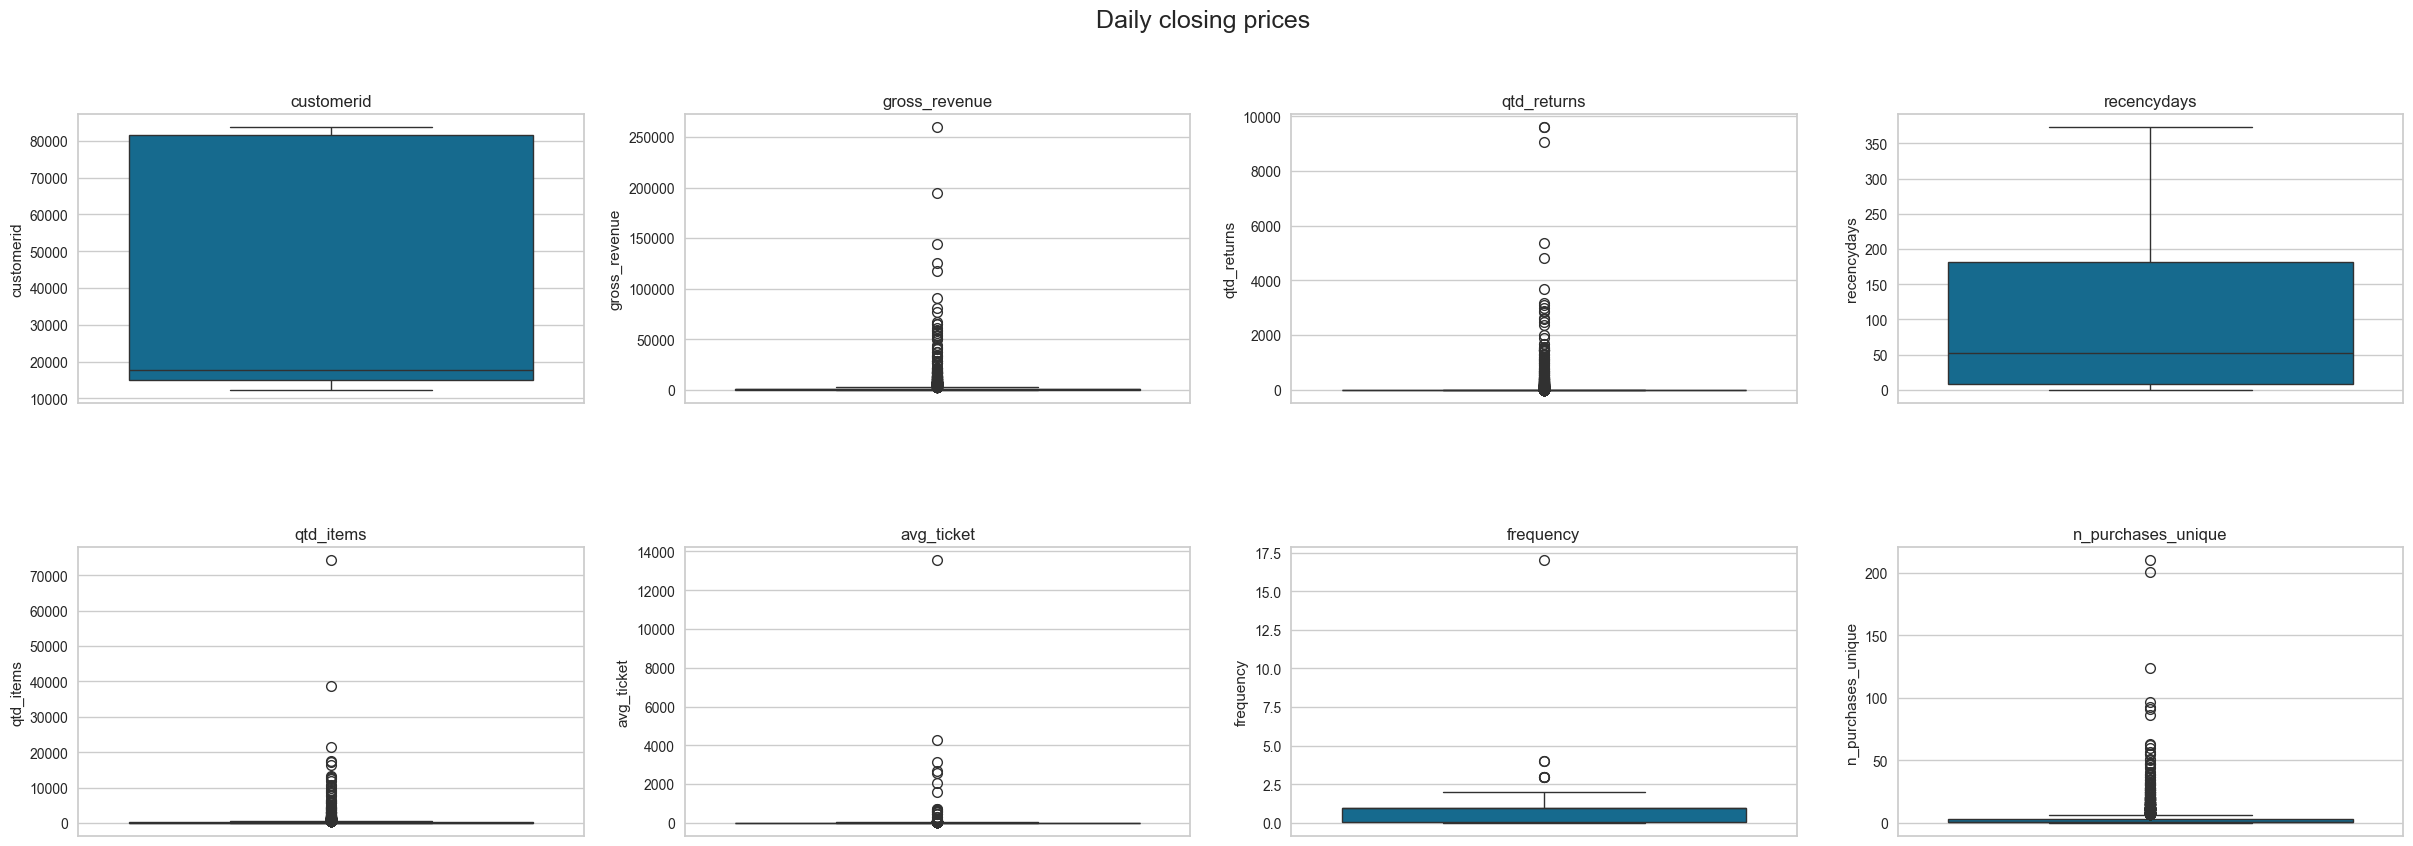

In [49]:
df6=df5.copy()
plt.figure(figsize=(30, 15));
plt.subplots_adjust(hspace=0.5);
plt.suptitle("Daily closing prices", fontsize=18, y=0.95);

tickers = df5.select_dtypes(exclude='object').columns;


# loop through the length of tickers and keep track of index
for n, ticker in enumerate(tickers):
    # add a new subplot iteratively
    ax = plt.subplot(3, 4, n + 1)

    sns.boxplot(data=df6[ticker])

    ax.set_title(ticker)


In [50]:
# import glob

# files = glob.glob('src/rescalers/*')
# for f in files:
#     os.remove(f)

# dic_scalers = {}

# mms = MinMaxScaler()

# mms_cols = ['recencydays','avg_ticket', 'frequency','gross_revenue', 'qtd_returns']

# for i in mms_cols:
#      df6[[i]] = mms.fit_transform(df6[[i]])
#      #pickle.dump(mms, open(f"src/rescalers/{i}_minmax.pkl",'wb'))
#      dic_scalers[f"{i}_minmax"] = mms


# rs = RobustScaler()

# robust_cols = ['qtd_items', "n_purchases_unique"]

# for i in robust_cols:
#      df6[robust_cols] = rs.fit_transform(df6[[i]])
#      #pickle.dump(rs, open(f"src/rescalers/{i}_robust.pkl",'wb'))
#      dic_scalers[f"{i}_robustscaler"] = rs

# pickle.dump(dic_scalers, open(f"src/rescalers/rescalers.pkl",'wb'))

# df6.head()

In [51]:
df6=df5.copy()

files = glob.glob('src/rescalers/*')
for f in files:
    os.remove(f)

mms = MinMaxScaler()

mms_cols = ['recencydays','avg_ticket', 'frequency','gross_revenue', 'qtd_returns']
df6[mms_cols] = mms.fit_transform(df6[mms_cols])
pickle.dump(mms, open(f"src/rescalers/minmax.pkl",'wb'))


rs = RobustScaler()

robust_cols = ['qtd_items', "n_purchases_unique"]
df6[robust_cols] = rs.fit_transform(df6[robust_cols])
pickle.dump(rs, open(f"src/rescalers/robust.pkl",'wb'))

In [52]:
df5.head()

,customerid,gross_revenue,qtd_returns,recencydays,qtd_items,avg_ticket,frequency,n_purchases_unique
0,17850,5391.21,0.0,372.0,35.0,154.034571,17.000000,34.0
1,13047,3237.54,0.0,31.0,132.0,24.526818,0.029155,10.0
2,12583,7281.38,0.0,2.0,1569.0,4.640778,0.040323,15.0
3,13748,948.25,0.0,95.0,169.0,5.610947,0.017921,5.0
4,15100,876.00,0.0,333.0,48.0,18.250000,0.073171,3.0


# 7.0 Hyperparameter Tuning

In [53]:
df7=df6.copy()
X=df7.drop(columns=['customerid'])
clusters= [2, 3, 4, 5,6, 7, 8]

In [54]:
X.head(1)

,gross_revenue,qtd_returns,recencydays,qtd_items,avg_ticket,frequency,n_purchases_unique
0,0.020763,0.0,0.997319,-0.160256,0.011375,1.0,16.5


## 7.1 KMeans


[0.9917611238218654,
 0.9619211973075392,
 0.9431219297354039,
 0.8320504845580803,
 0.8087599605332207,
 0.7342092107410069,
 0.6273657002080887]

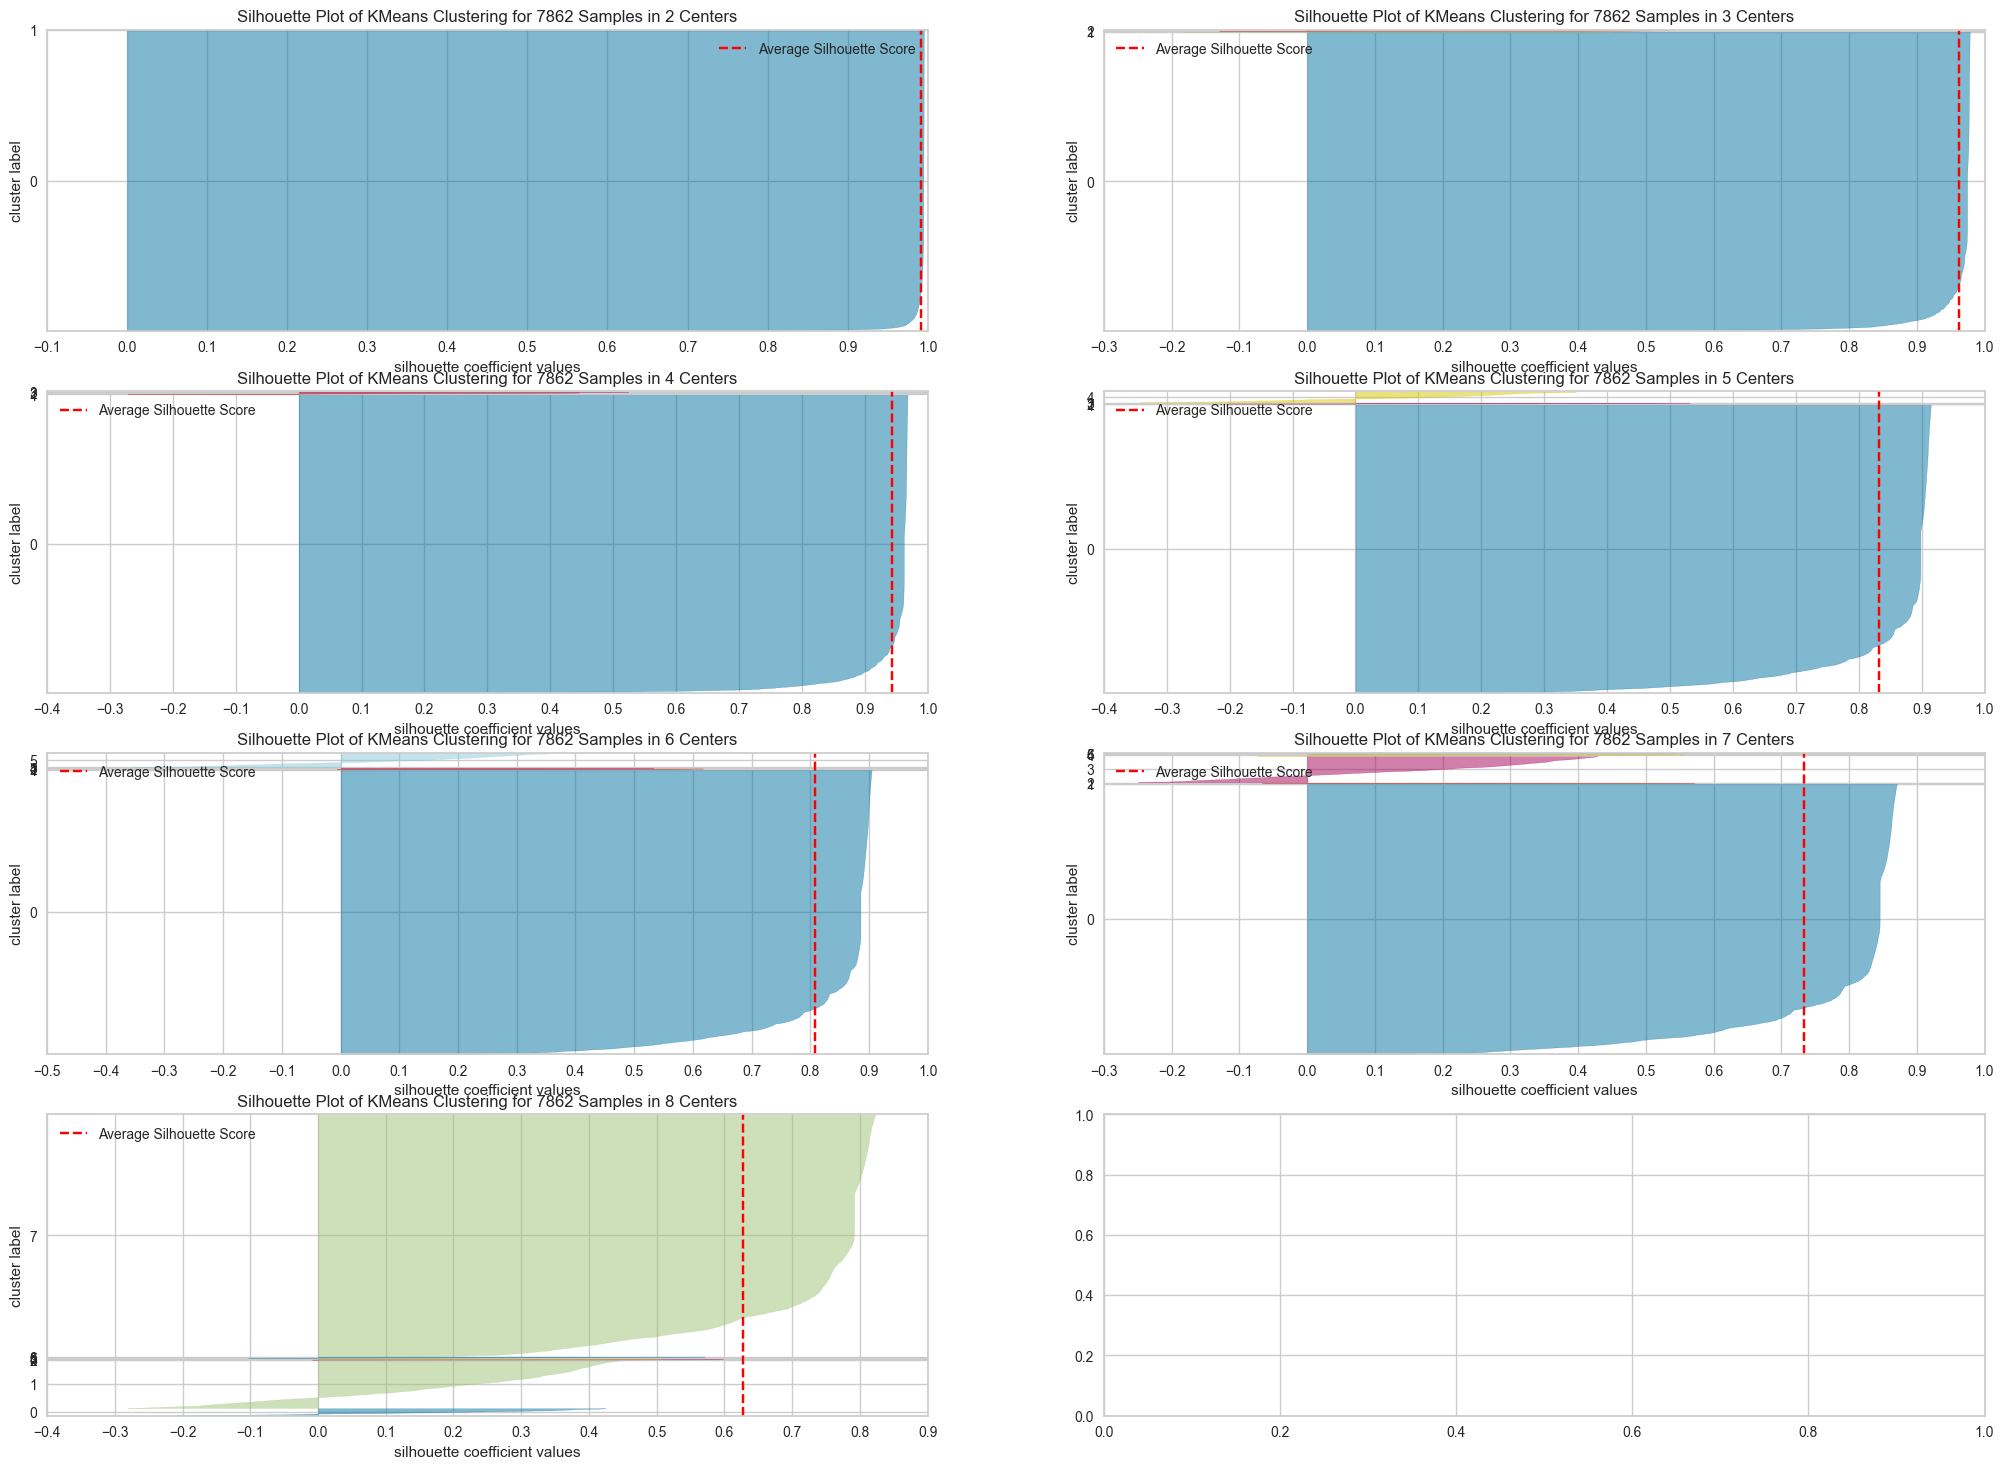

In [55]:
fig, ax = plt.subplots( 4, 2, figsize=(25, 18))

kmeans_list = []
for k in clusters:
    km = c.KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    vis_silhouette = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    vis_silhouette.fit(X)
    vis_silhouette.finalize()
    kmeans_list.append(vis_silhouette.silhouette_score_)
kmeans_list

In [ ]:
# Kmeans performed poorly on the preprocessed data, let's see other algorithms.

## 7.2 GMM

In [56]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )
gmm_list

[0.9917611238218654,
 0.3238445496904041,
 0.15380703307162383,
 0.3906599692190622,
 0.20867877690337278,
 0.22836353407234636,
 0.2330333716514296]

Text(0.5, 1.0, 'Sil x K')

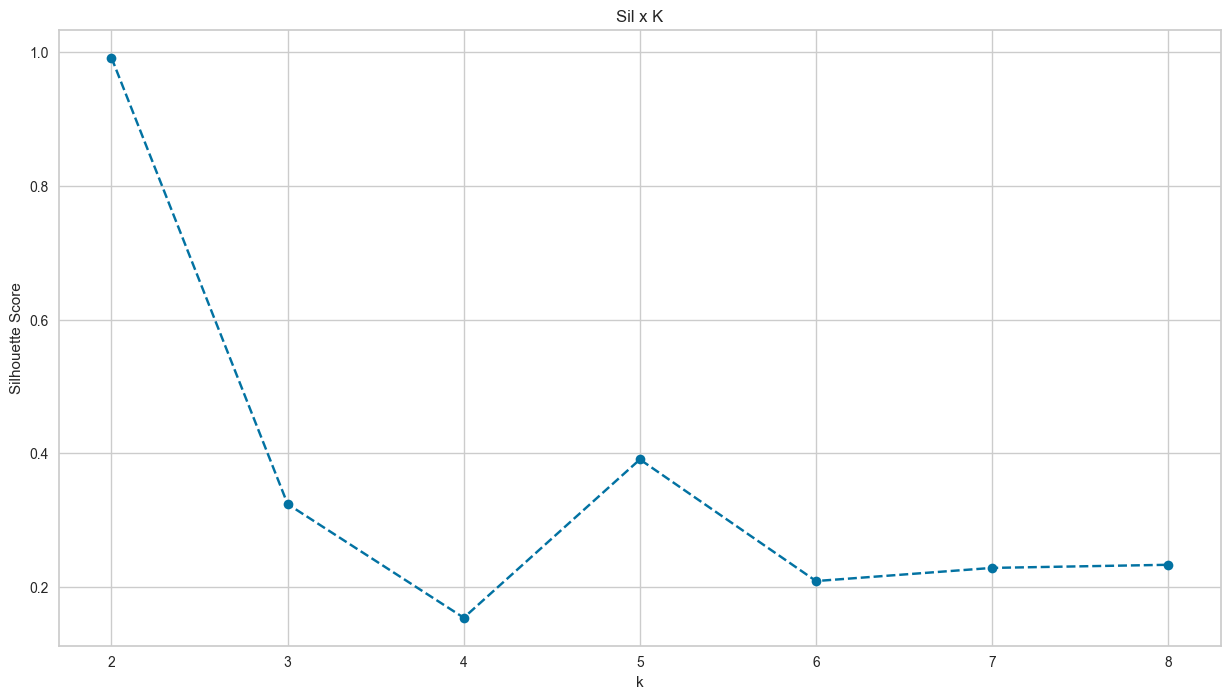

In [57]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k')
plt.ylabel( 'Silhouette Score')
plt.title( 'Sil x K')

## 7.3 Hierarchical Clustering

[]

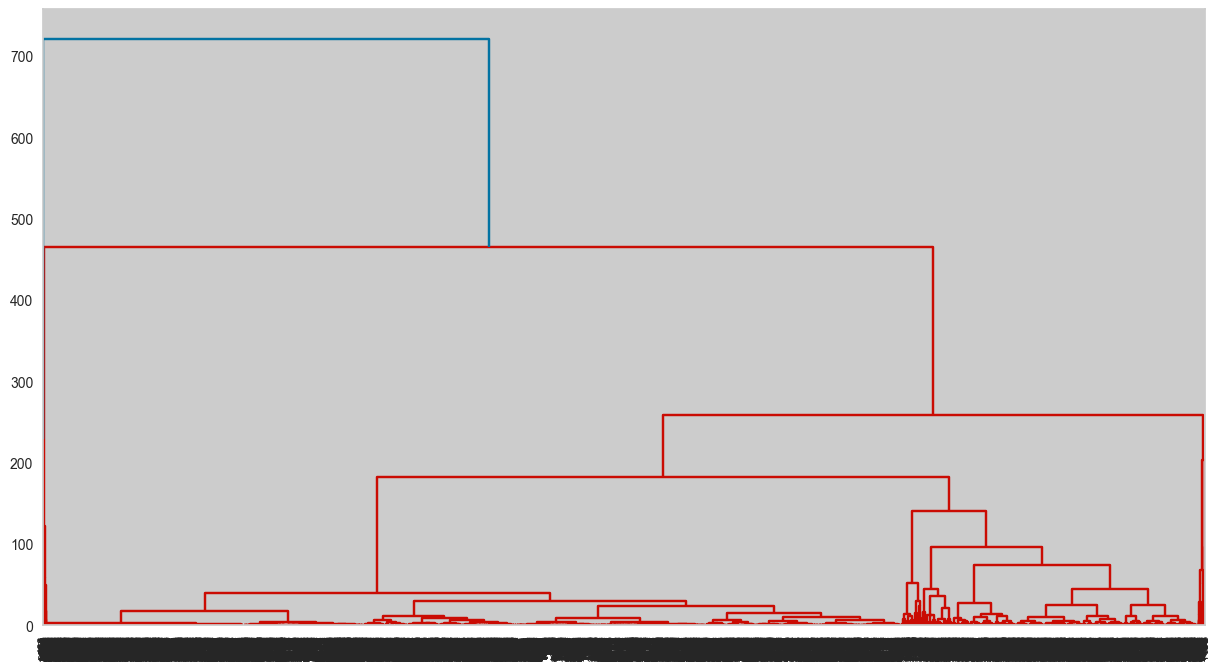

In [58]:
hc_model = hc.linkage( X, 'ward' )
hc.dendrogram( 
    hc_model, 
    leaf_rotation=90,
    leaf_font_size=8
)
plt.plot()

In [59]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' ) 

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )
hc_list

[0.9917611238218654,
 0.9659349410341053,
 0.9250043103081963,
 0.9249802697987878,
 0.9107328766698972,
 0.5701476865756269,
 0.572653420430055]

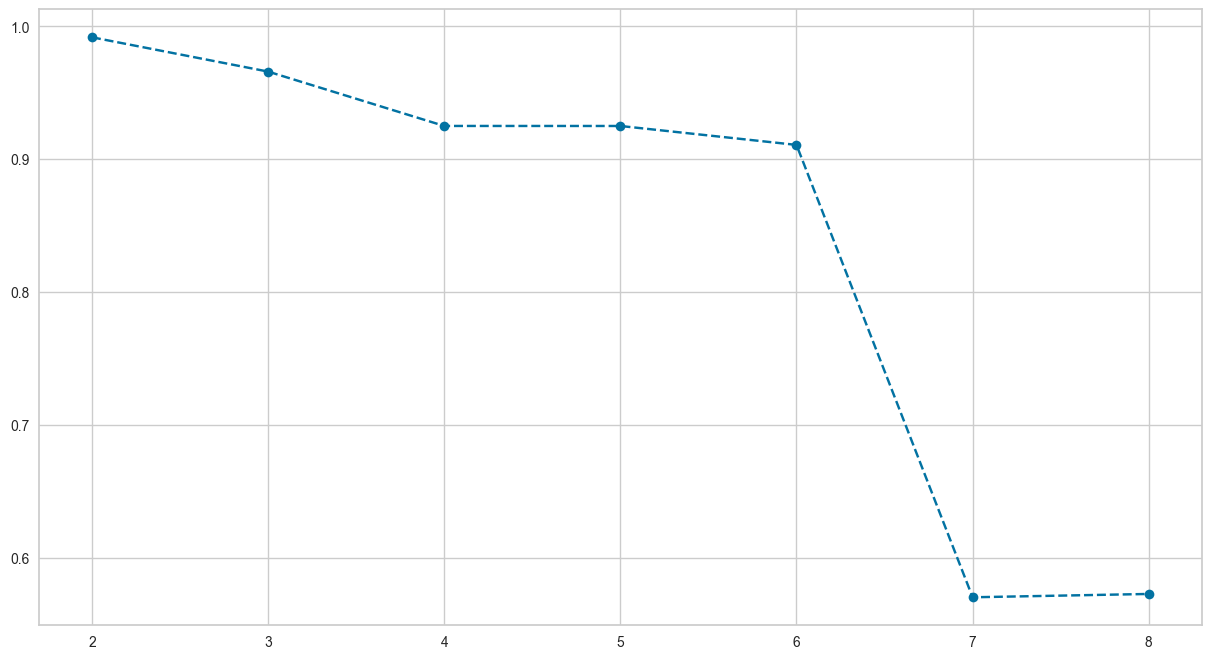

In [230]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' ) 

In [232]:
# These high sillhouete scores seems suspicious, let's find out if the cluster are balanced in size

In [229]:
aux0=df5.copy()


hc_model = hc.linkage( X, 'ward' )

# model predict
aux0['cluster'] = hc.fcluster( hc_model, 6, criterion='maxclust' ) 

aux0["cluster"].value_counts()

cluster
4    7796
5      39
3      18
6       7
1       1
2       1
Name: count, dtype: int64

In [ ]:
# As expected, the hierarchical algorithm couldn't separate well the customers, let's keep trying other techniques.

## 7.5 PCA reducer

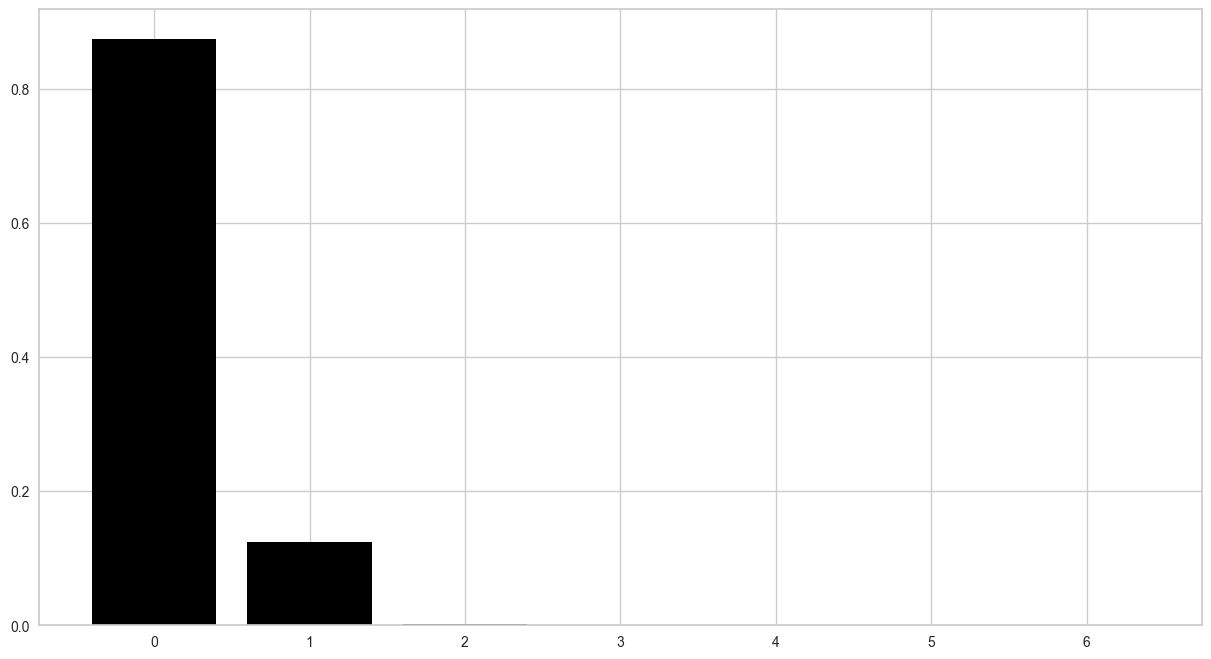

In [61]:
pca = PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

features = range( pca.n_components_)

plt.bar( features, pca.explained_variance_ratio_, color='black')

df_pca=pd.DataFrame(principal_components)

<Axes: xlabel='0', ylabel='1'>

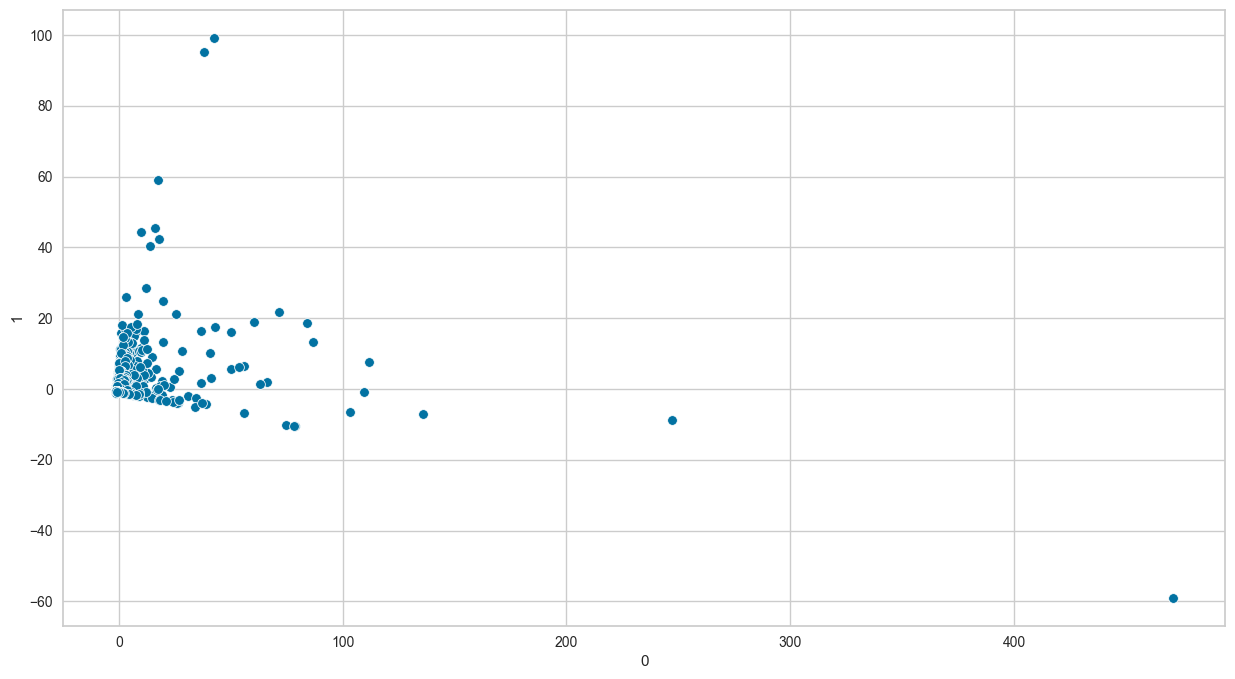

In [62]:
sns.scatterplot(x=0 , y=1, data=df_pca)

In [63]:
#PCA couldn't separate well the datapoints, for clustering problems, it's good to have the data separate in groups as much as possible.

## 7.6 TSNE Reducer + Means

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

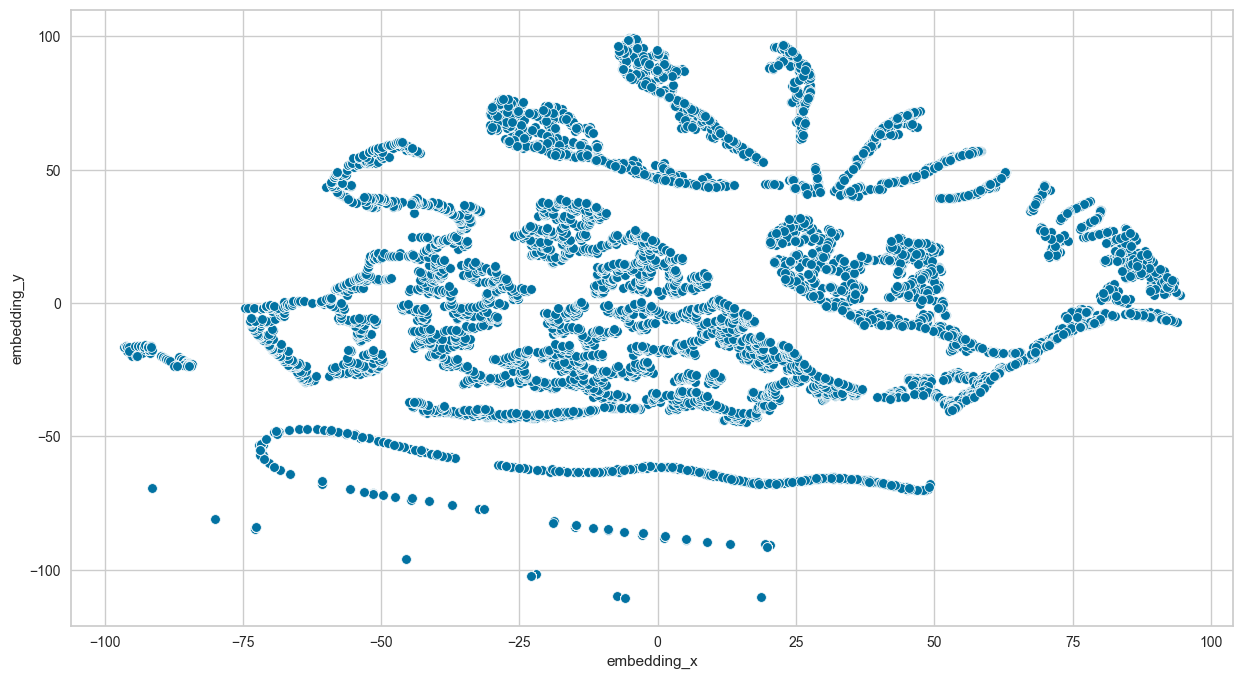

In [64]:
reducer = TSNE(n_components=2, random_state=42)
aux0 = X.copy()
embedding = reducer.fit_transform( X )

# embedding
aux0['embedding_x']=embedding[:,0]
aux0['embedding_y']=embedding[:,1]

X_TSNE = pd.concat([aux0['embedding_x'], aux0["embedding_y"]], axis=1)

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y', data=X_TSNE)

In [65]:
#TSNE performed better than PCA, we can see some groups formed by the embedding, let's find out if a KMeans algorithm cam create good clusters with this embedding.

[0.3711529,
 0.3796321,
 0.3807053,
 0.36954477,
 0.36551914,
 0.37705278,
 0.37812403]

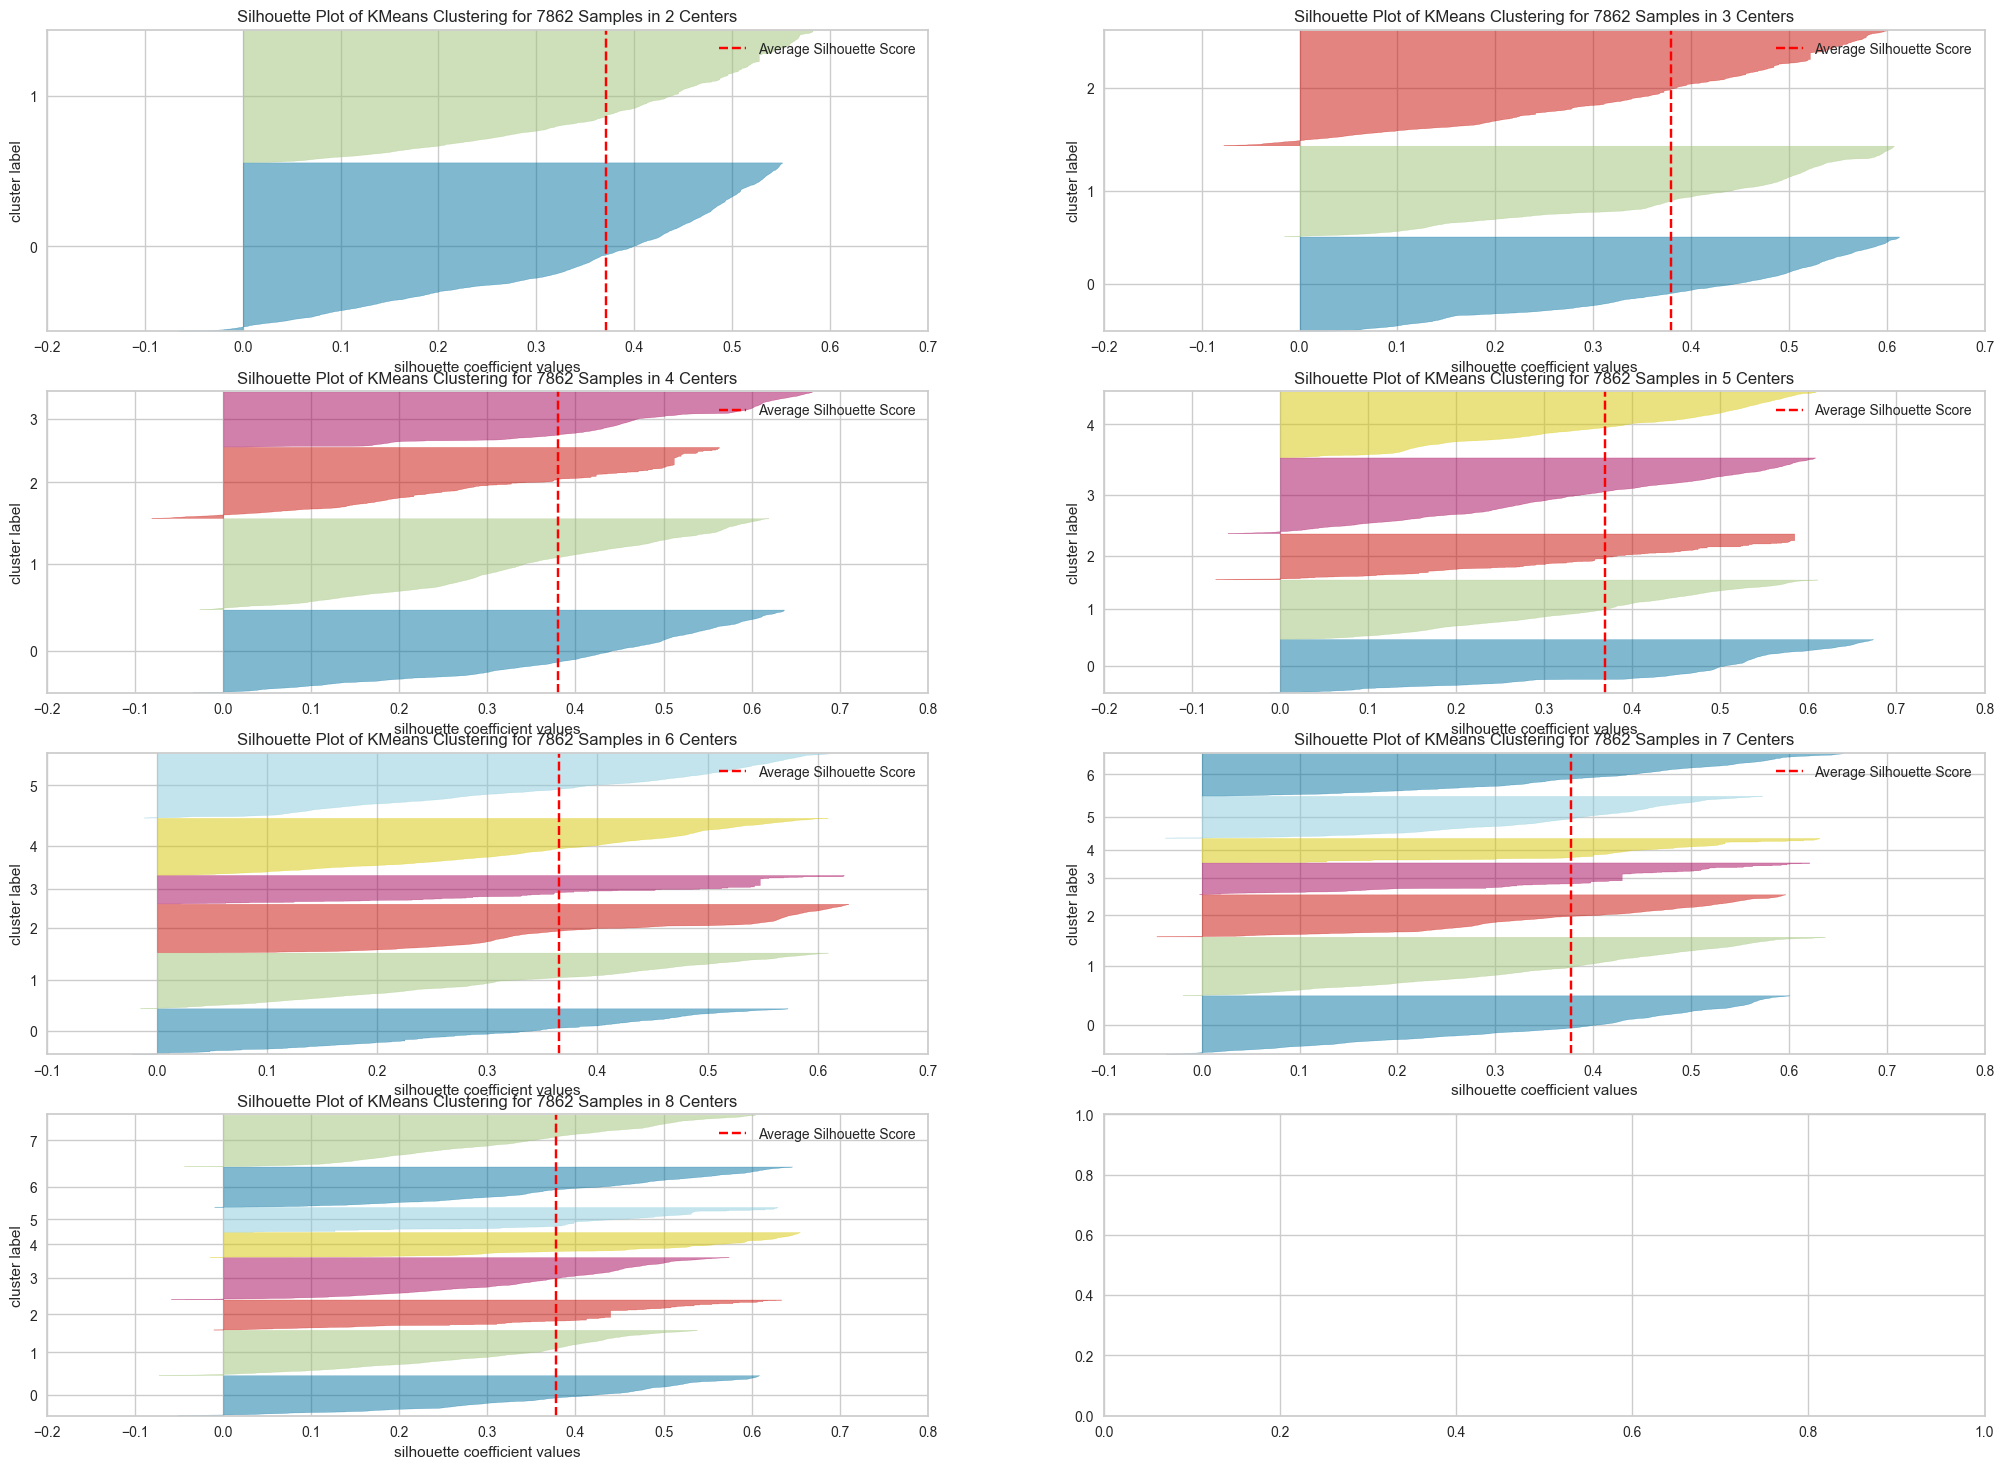

In [66]:
fig, ax = plt.subplots( 4, 2, figsize=(25, 18))

TSNE_KMeans=[]
for k in clusters:
    km = c.KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    vis_silhouette_tsne = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    vis_silhouette_tsne.fit(X_TSNE)
    vis_silhouette_tsne.finalize()
    TSNE_KMeans.append(vis_silhouette_tsne.silhouette_score_)
TSNE_KMeans

In [67]:
np.max(TSNE_KMeans)

0.3807053

In [233]:
#The highest silhouette score was of 0.38, nevethlesess let's keep trying other techniques

## 7.7 UMAP Reducer + KMeans+

p:\Python\GitHub\insiders_clustering\dev_env\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


C:\Users\kosmo\AppData\Local\Temp\ipykernel_16312\3806248578.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='umap_component_x',y='umap_component_y',


<Axes: xlabel='umap_component_x', ylabel='umap_component_y'>

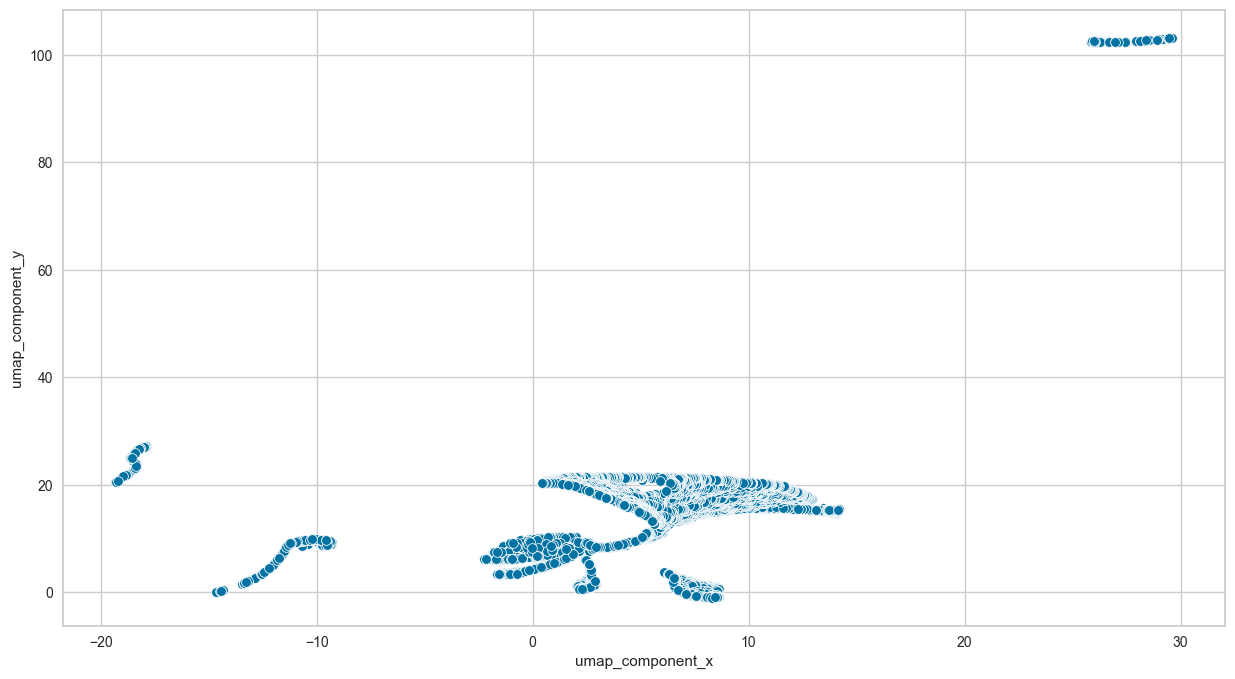

In [254]:
reducer = umap.UMAP(n_neighbors = 300,
                    random_state = 42,
                    n_components = 2)
embedding_umap = reducer.fit_transform( X )

# # embedding
df_umap = pd.DataFrame({"umap_component_x": embedding_umap[:,0],
                         "umap_component_y":embedding_umap[:,1]})

# plot UMAP
sns.scatterplot(x='umap_component_x',y='umap_component_y',
                palette=sns.color_palette('hls'),
                data=df_umap)

In [70]:
# UMAP created a good separation and groups among in the data points, let's find out if a algorith can create good clusters with it :)

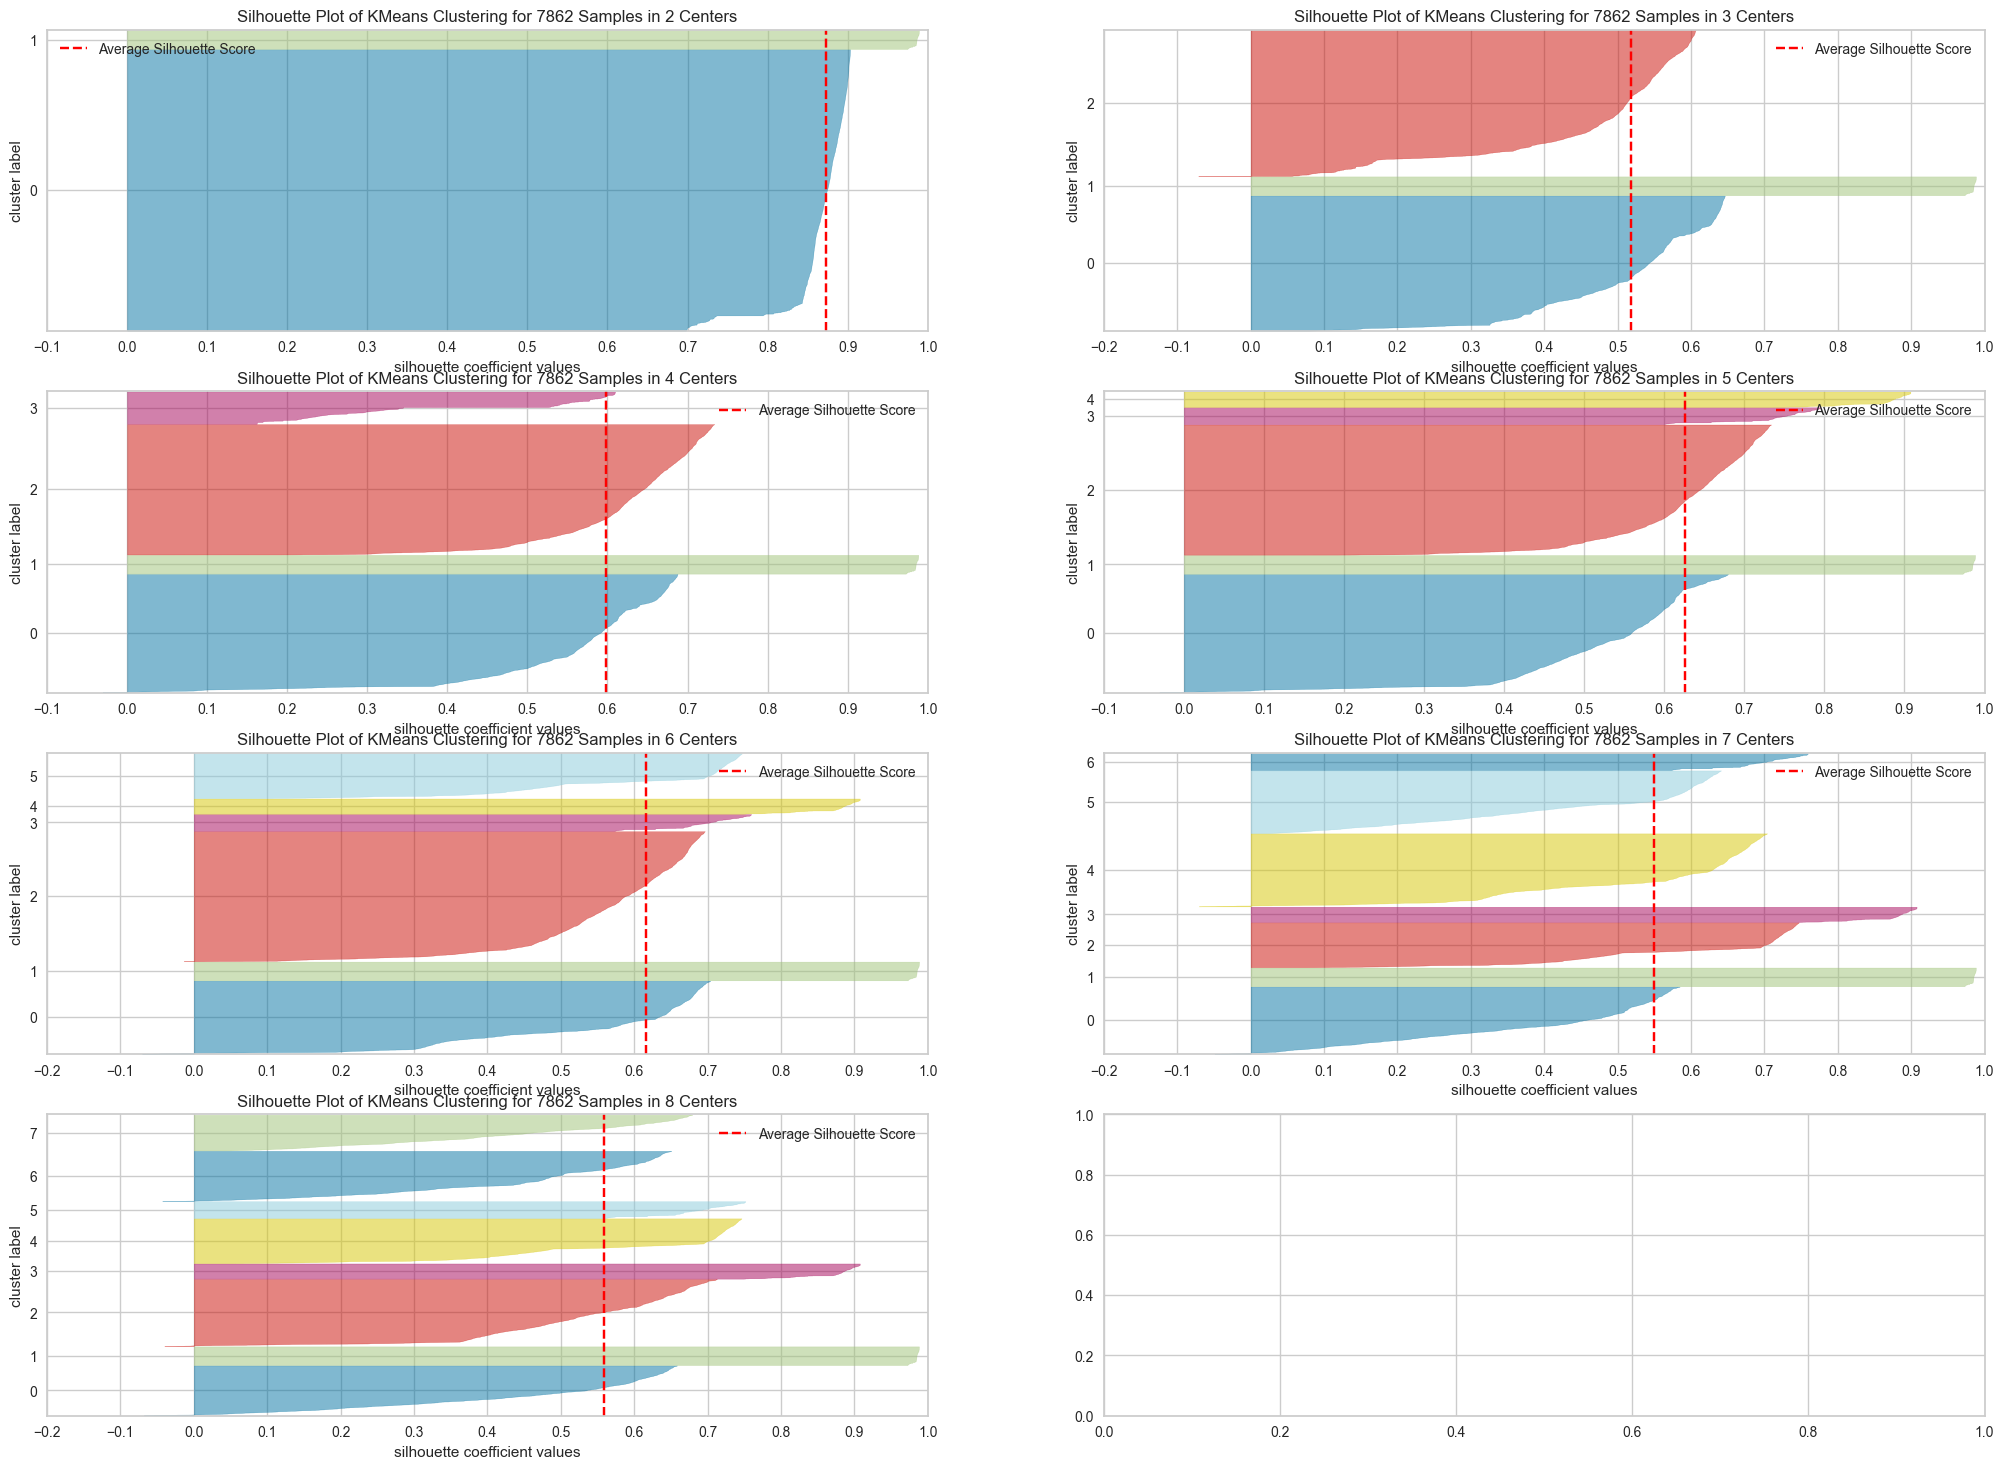

In [256]:
clusters=[2, 3, 4, 5, 6, 7, 8]

fig, ax = plt.subplots( 4, 2, figsize=(25, 18))

clusters_scores = []

for k in clusters:
    km = c.KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    vis_silhouette_umap = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    vis_silhouette_umap.fit(df_umap)
    vis_silhouette_umap.finalize()
    clusters_scores.append([k,vis_silhouette_umap.silhouette_score_])


scores = pd.DataFrame( clusters_scores, columns = ["n_clusters","silhouette_score"] )

In [257]:
scores.head()

,n_clusters,silhouette_score
0,2,0.87
1,3,0.52
2,4,0.60
3,5,0.63
4,6,0.62


In [ ]:
#wow, it seems that a Kmeans++ trained in a UMAP reduced data way better than the previous trials, let's see if the clusters are well separated in terms of size and marketing
#actionable characteristcs
#let's start with the highest silhouette_score, that is it, 5 clusters

p:\Python\GitHub\insiders_clustering\dev_env\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


C:\Users\kosmo\AppData\Local\Temp\ipykernel_16312\2641131968.py:7: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(x=df_umap['umap_component_x'],y=df_umap['umap_component_y'],


<Axes: xlabel='umap_component_x', ylabel='umap_component_y'>

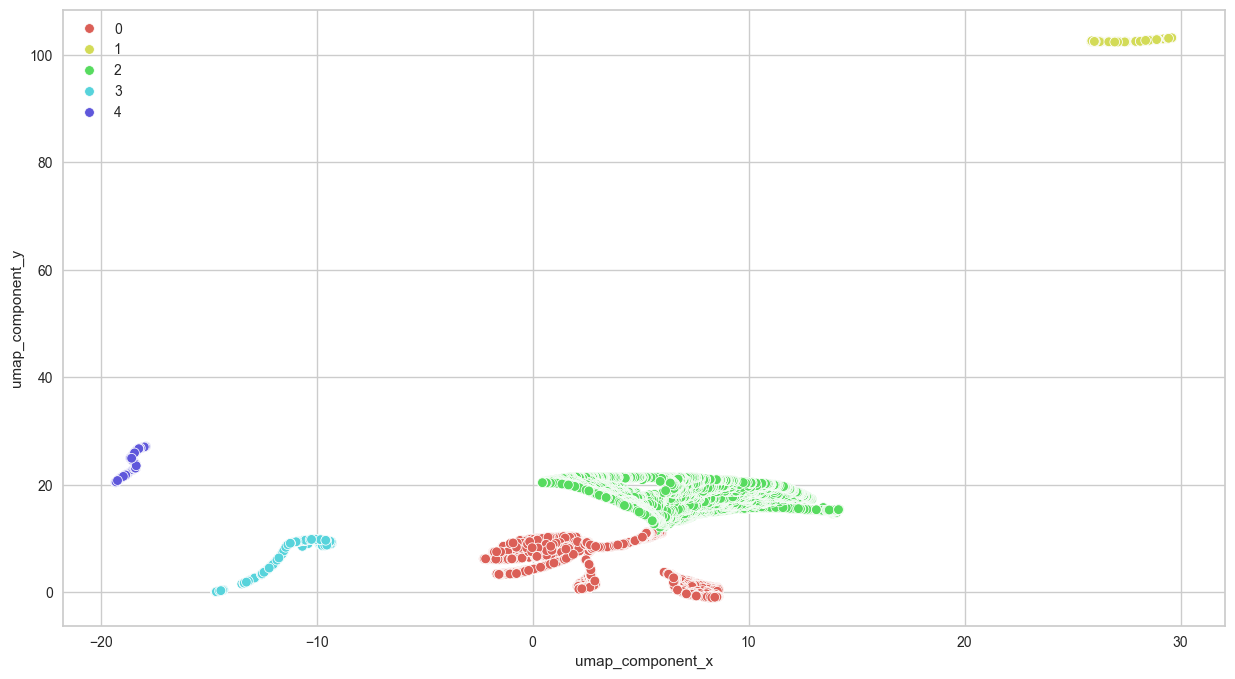

In [332]:
# two cluster are too low, for a segmentation, let's try it out with 4

km_umap = c.KMeans(n_clusters=5, init="k-means++", n_init=10, max_iter=100, random_state=42)
km_umap.fit(df_umap)
vis_silhouette_umap.fit(df_umap)
labs = km_umap.predict( df_umap )
sns.scatterplot(x=df_umap['umap_component_x'],y=df_umap['umap_component_y'],
                palette=sns.color_palette('hls'), hue=labs)

In [334]:
aux0 = df5.copy()
aux0["cluster"] = labs
aux0["count"] = 1
aux0 = aux0.groupby("cluster").sum()
aux0 = aux0/aux0.sum()
aux0.style.highlight_max( color='purple', axis=0 )

,customerid,gross_revenue,qtd_returns,recencydays,qtd_items,avg_ticket,frequency,n_purchases_unique,count
cluster,,,,,,,,,
0,0.167835,0.863026,0.000000,0.255830,0.877466,0.325960,0.098319,0.834278,0.394810
1,0.113479,0.000000,0.014834,0.000000,0.000000,0.000000,0.093428,0.000000,0.062707
2,0.523884,0.136974,0.000000,0.744170,0.122534,0.674040,0.648498,0.165722,0.435258
3,0.102240,0.000000,0.920723,0.000000,0.000000,0.000000,0.083763,0.000000,0.056220
4,0.092563,0.000000,0.064443,0.000000,0.000000,0.000000,0.075993,0.000000,0.051005


## 7.7 Tree Based Embedding

In [139]:
# training dataset

a1 = X.drop(['gross_revenue'],axis=1)
y = X['gross_revenue']


# model definition
rf_model = RandomForestRegressor( n_estimators=100, random_state=42)

# model training

rf_model.fit( a1, y )

#leaf 

df_leaf = pd.DataFrame(rf_model.apply(a1))
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,6950,6957,7014,3869,7074,7168,6923,7128,7109,7191,...,7039,7077,7238,7051,6898,7084,7071,5425,7059,7238
1,4683,4713,4853,4811,4674,4944,4851,4607,4658,4714,...,4589,4889,4993,5022,5268,4685,6473,5123,4733,4992
2,7084,7139,5749,7137,7031,7210,7127,7083,7022,7144,...,7072,7124,6312,7088,6971,7044,7034,6523,7136,7153
3,5602,5316,5764,5661,5397,2674,2676,5574,5587,5266,...,5444,2418,2570,2787,2528,5457,5047,3017,5423,2728
4,3616,3803,3825,3754,3484,3919,3915,3724,3705,3796,...,3618,3697,3840,4031,3626,3708,3524,4261,3667,3953


### 7.7.1 Tree Based Embedding + TSNE

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

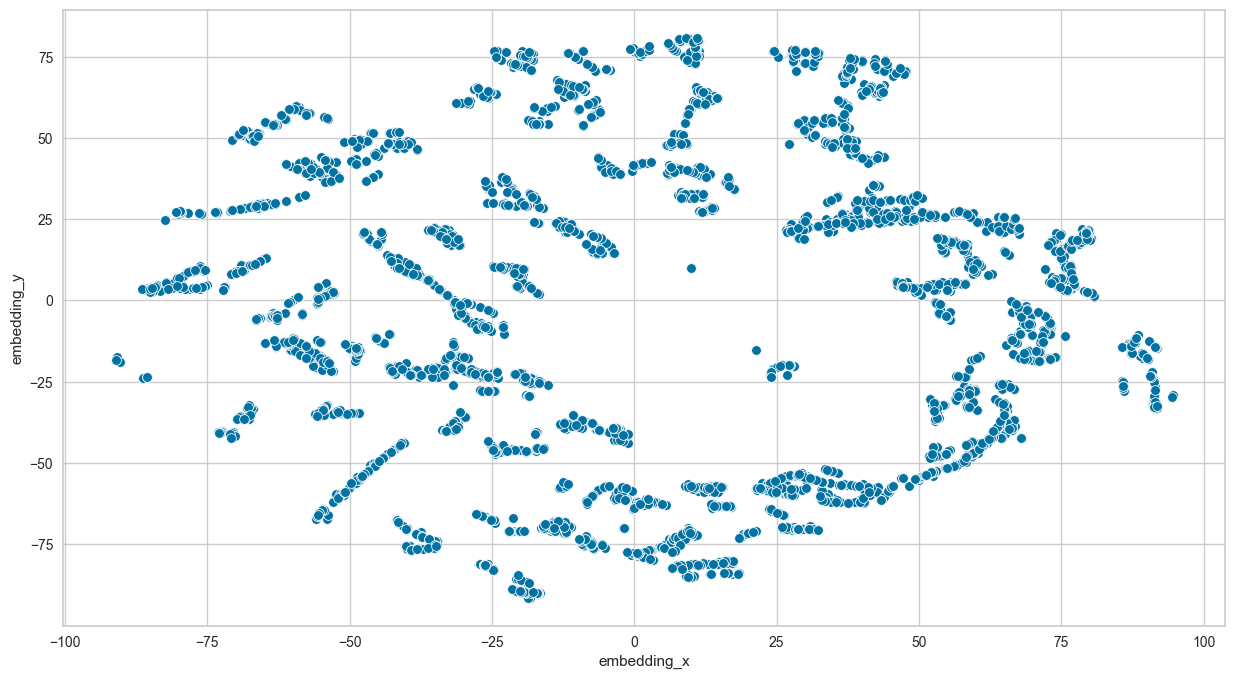

In [140]:
reducer = TSNE( random_state=42)

df_leaf_tsne = df_leaf.copy()

embedding_tree = reducer.fit_transform( df_leaf_tsne )


# embedding
df_leaf_tsne['embedding_x'] = embedding_tree[:,0]
df_leaf_tsne['embedding_y'] = embedding_tree[:,1]

df_tree_tsne = pd.concat([df_leaf_tsne["embedding_x"], df_leaf_tsne["embedding_y"]], axis=1)

# plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',
                data=df_leaf_tsne)

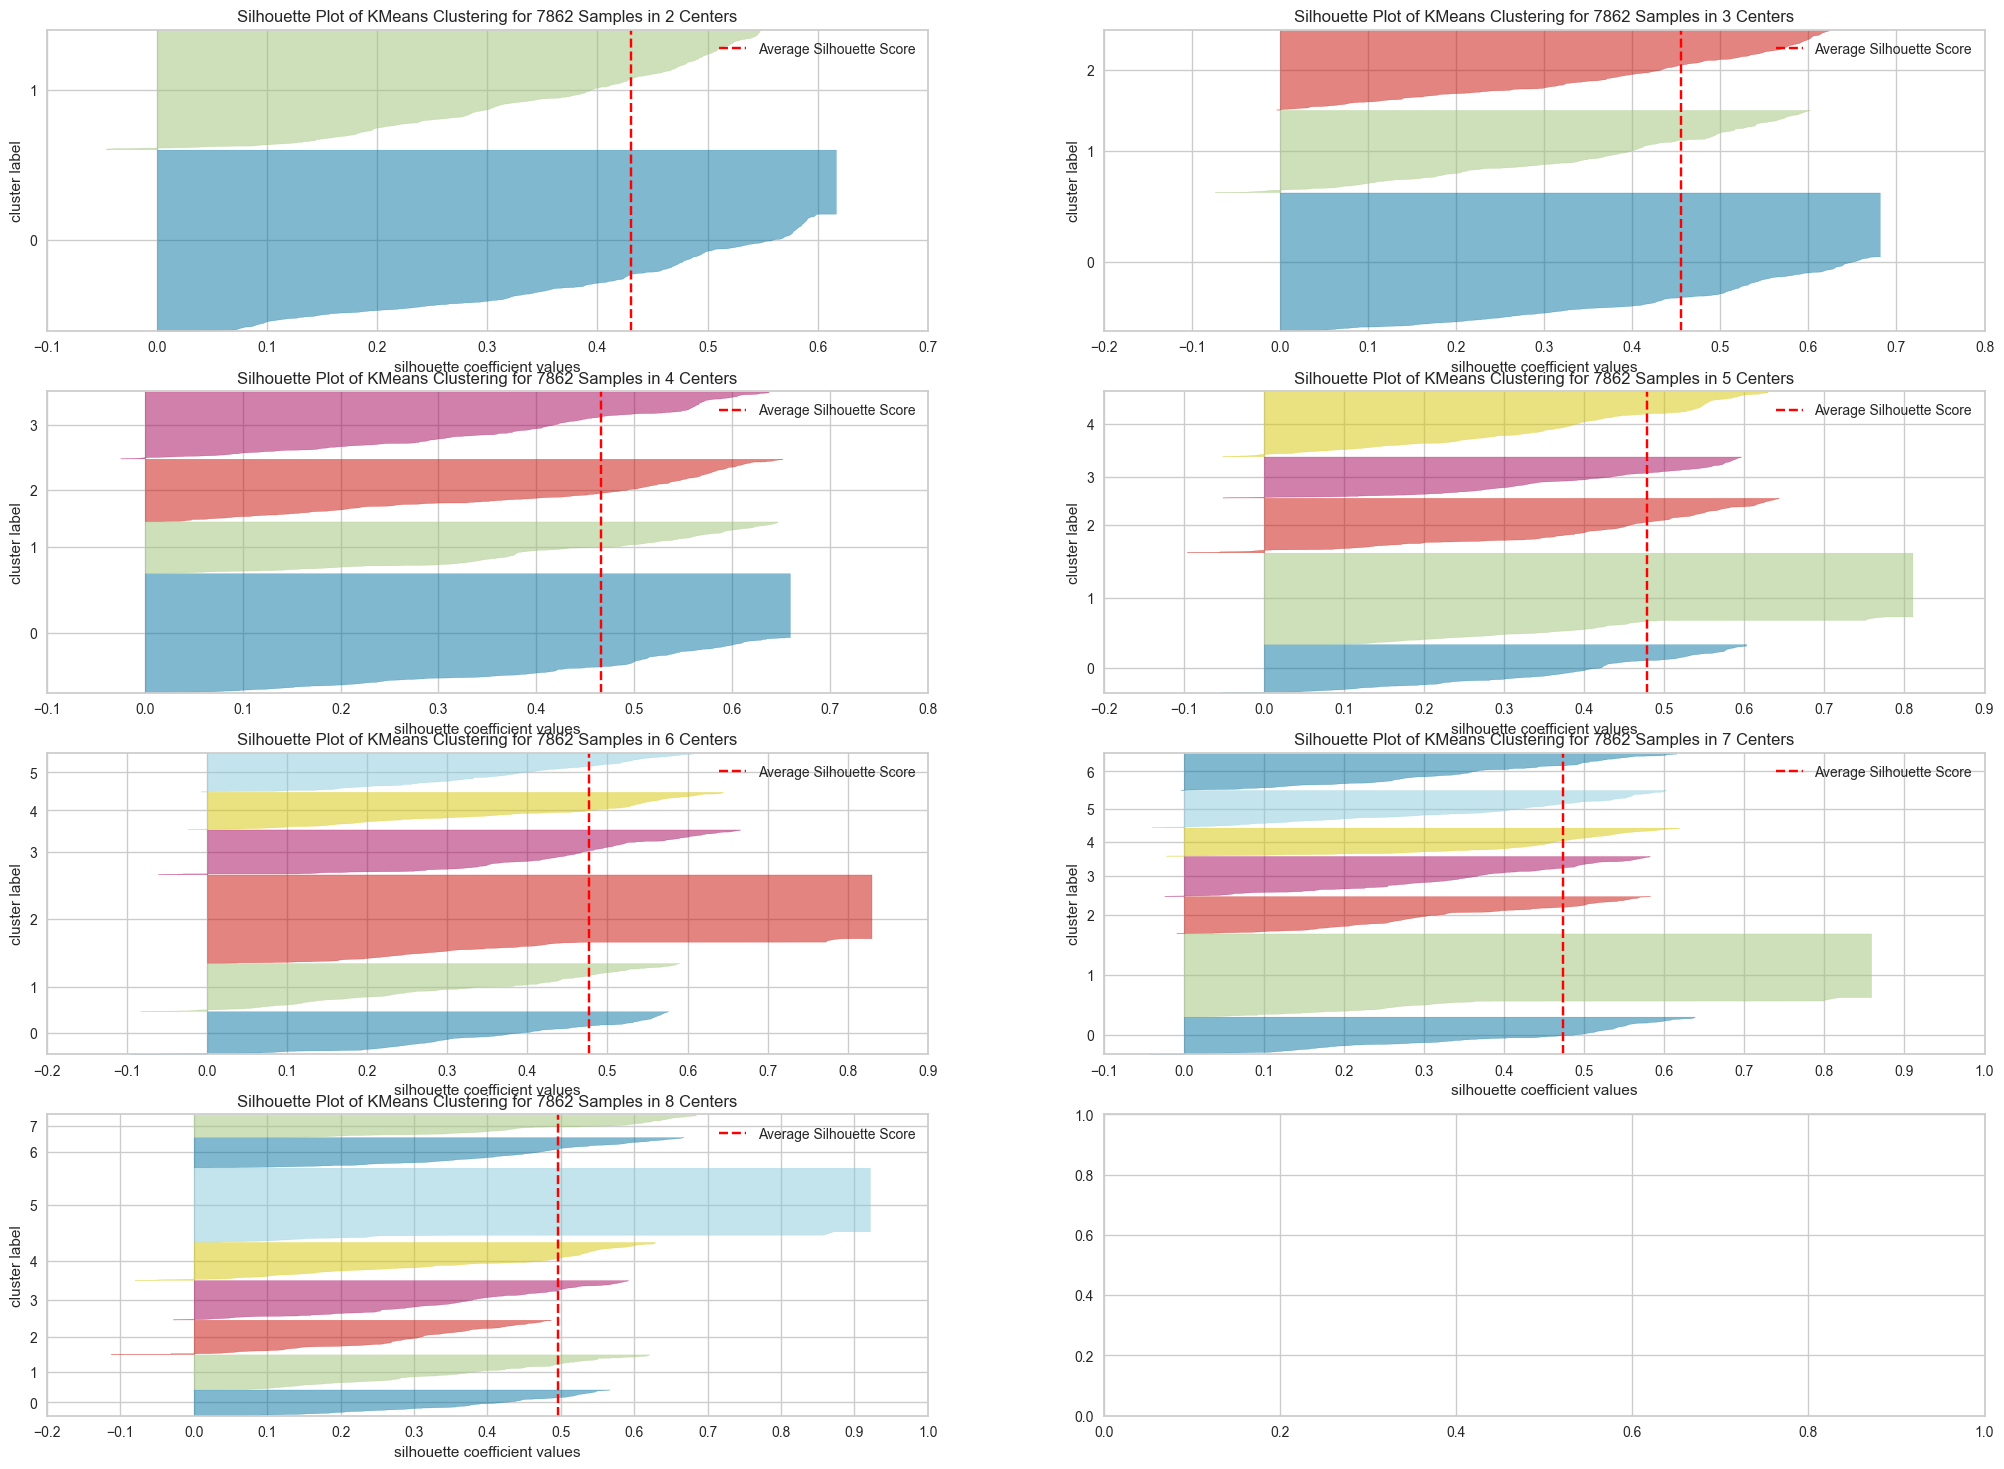

In [141]:
clusters=[2, 3, 4, 5, 6, 7, 8]

fig, ax = plt.subplots( 4, 2, figsize=(25, 18))

tree_tsne_scores = []

for k in clusters:
    km = c.KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    vis_silhouette_tree_tsne = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    vis_silhouette_tree_tsne.fit(df_tree_tsne)
    vis_silhouette_tree_tsne.finalize()
    tree_tsne_scores.append(vis_silhouette_tsne.silhouette_score_)

In [142]:
print(f"the highest silhouette score of a KMeans trained in a tree embedded + tsne reduced data was: ",np.max(tree_tsne_scores))

the highest silhouette score of a KMeans trained in a tree embedded + tsne reduced data was:  0.37812403


### 7.7.2 Tree Based Embedding + PCA

<BarContainer object of 100 artists>

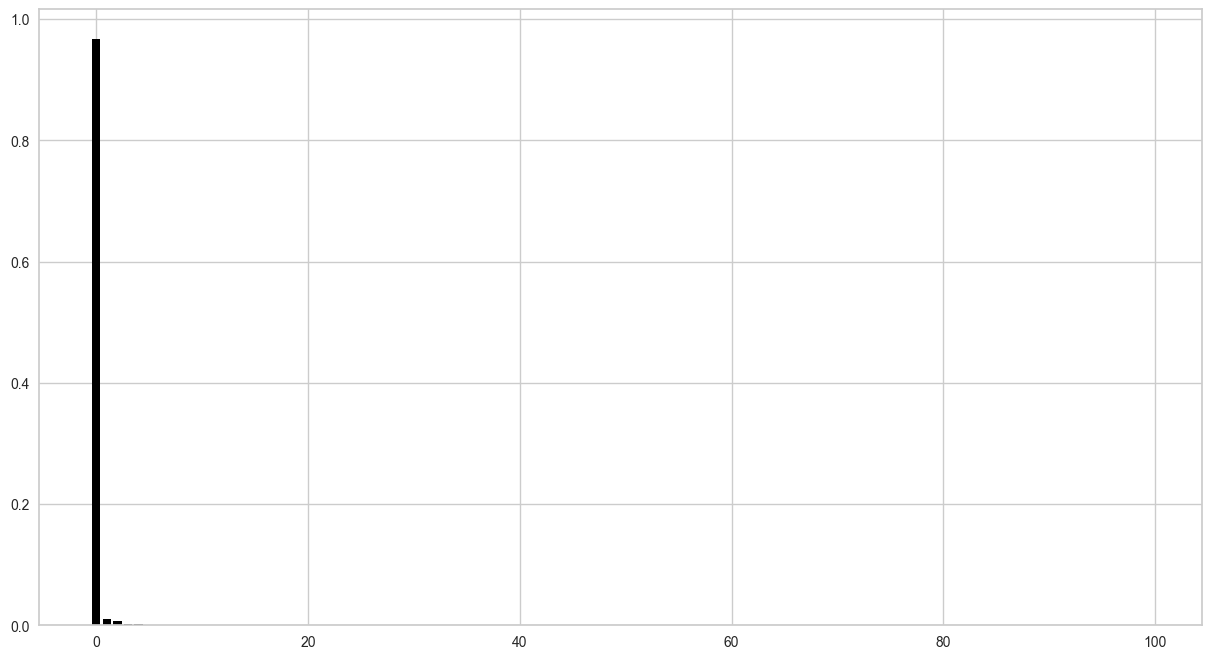

In [143]:
pca = PCA(n_components=df_leaf.shape[1])

principal_components = pca.fit_transform(df_leaf)

features = range( pca.n_components_)

plt.bar( features, pca.explained_variance_ratio_, color='black')

In [144]:
df_pca.head()

,0,1
0,42128.769441,1687.726249
1,24535.354169,1334.492227
2,43262.760134,1095.191621
3,16154.816547,10333.352423
4,10860.429392,-2126.034021


<Axes: xlabel='0', ylabel='1'>

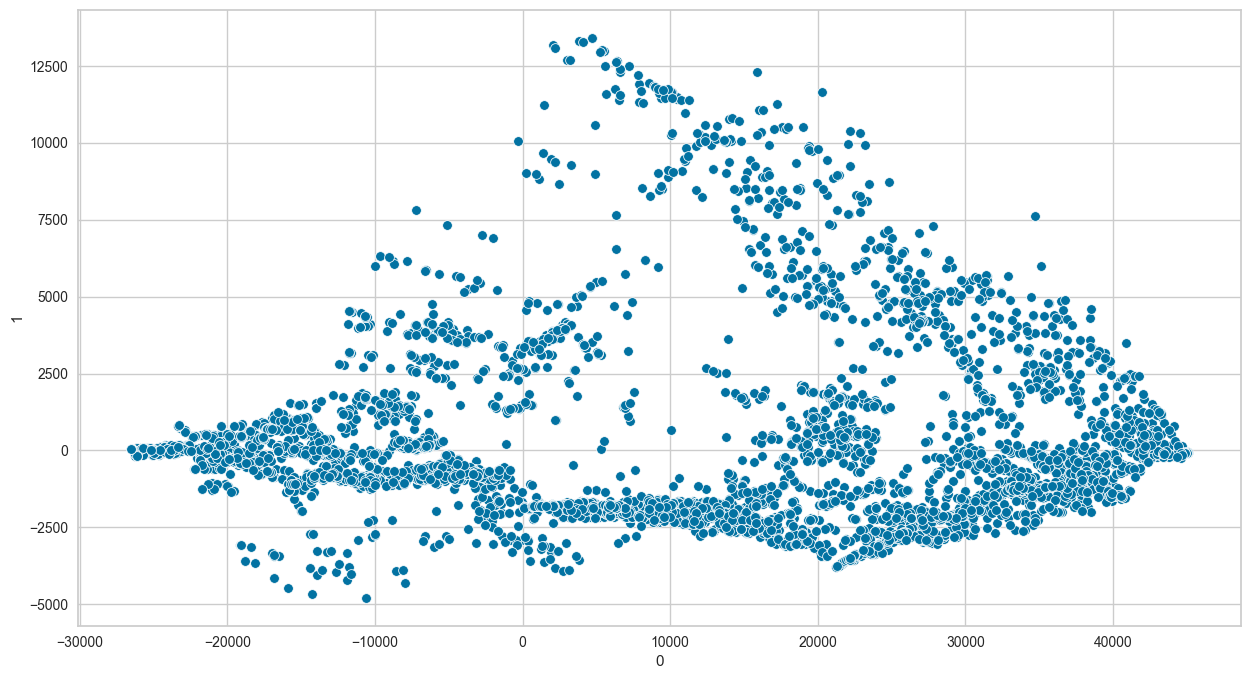

In [145]:
df_pca=pd.DataFrame(principal_components)
df_pca = df_pca[[0,1]]
sns.scatterplot(x=0 , y=1, data=df_pca)

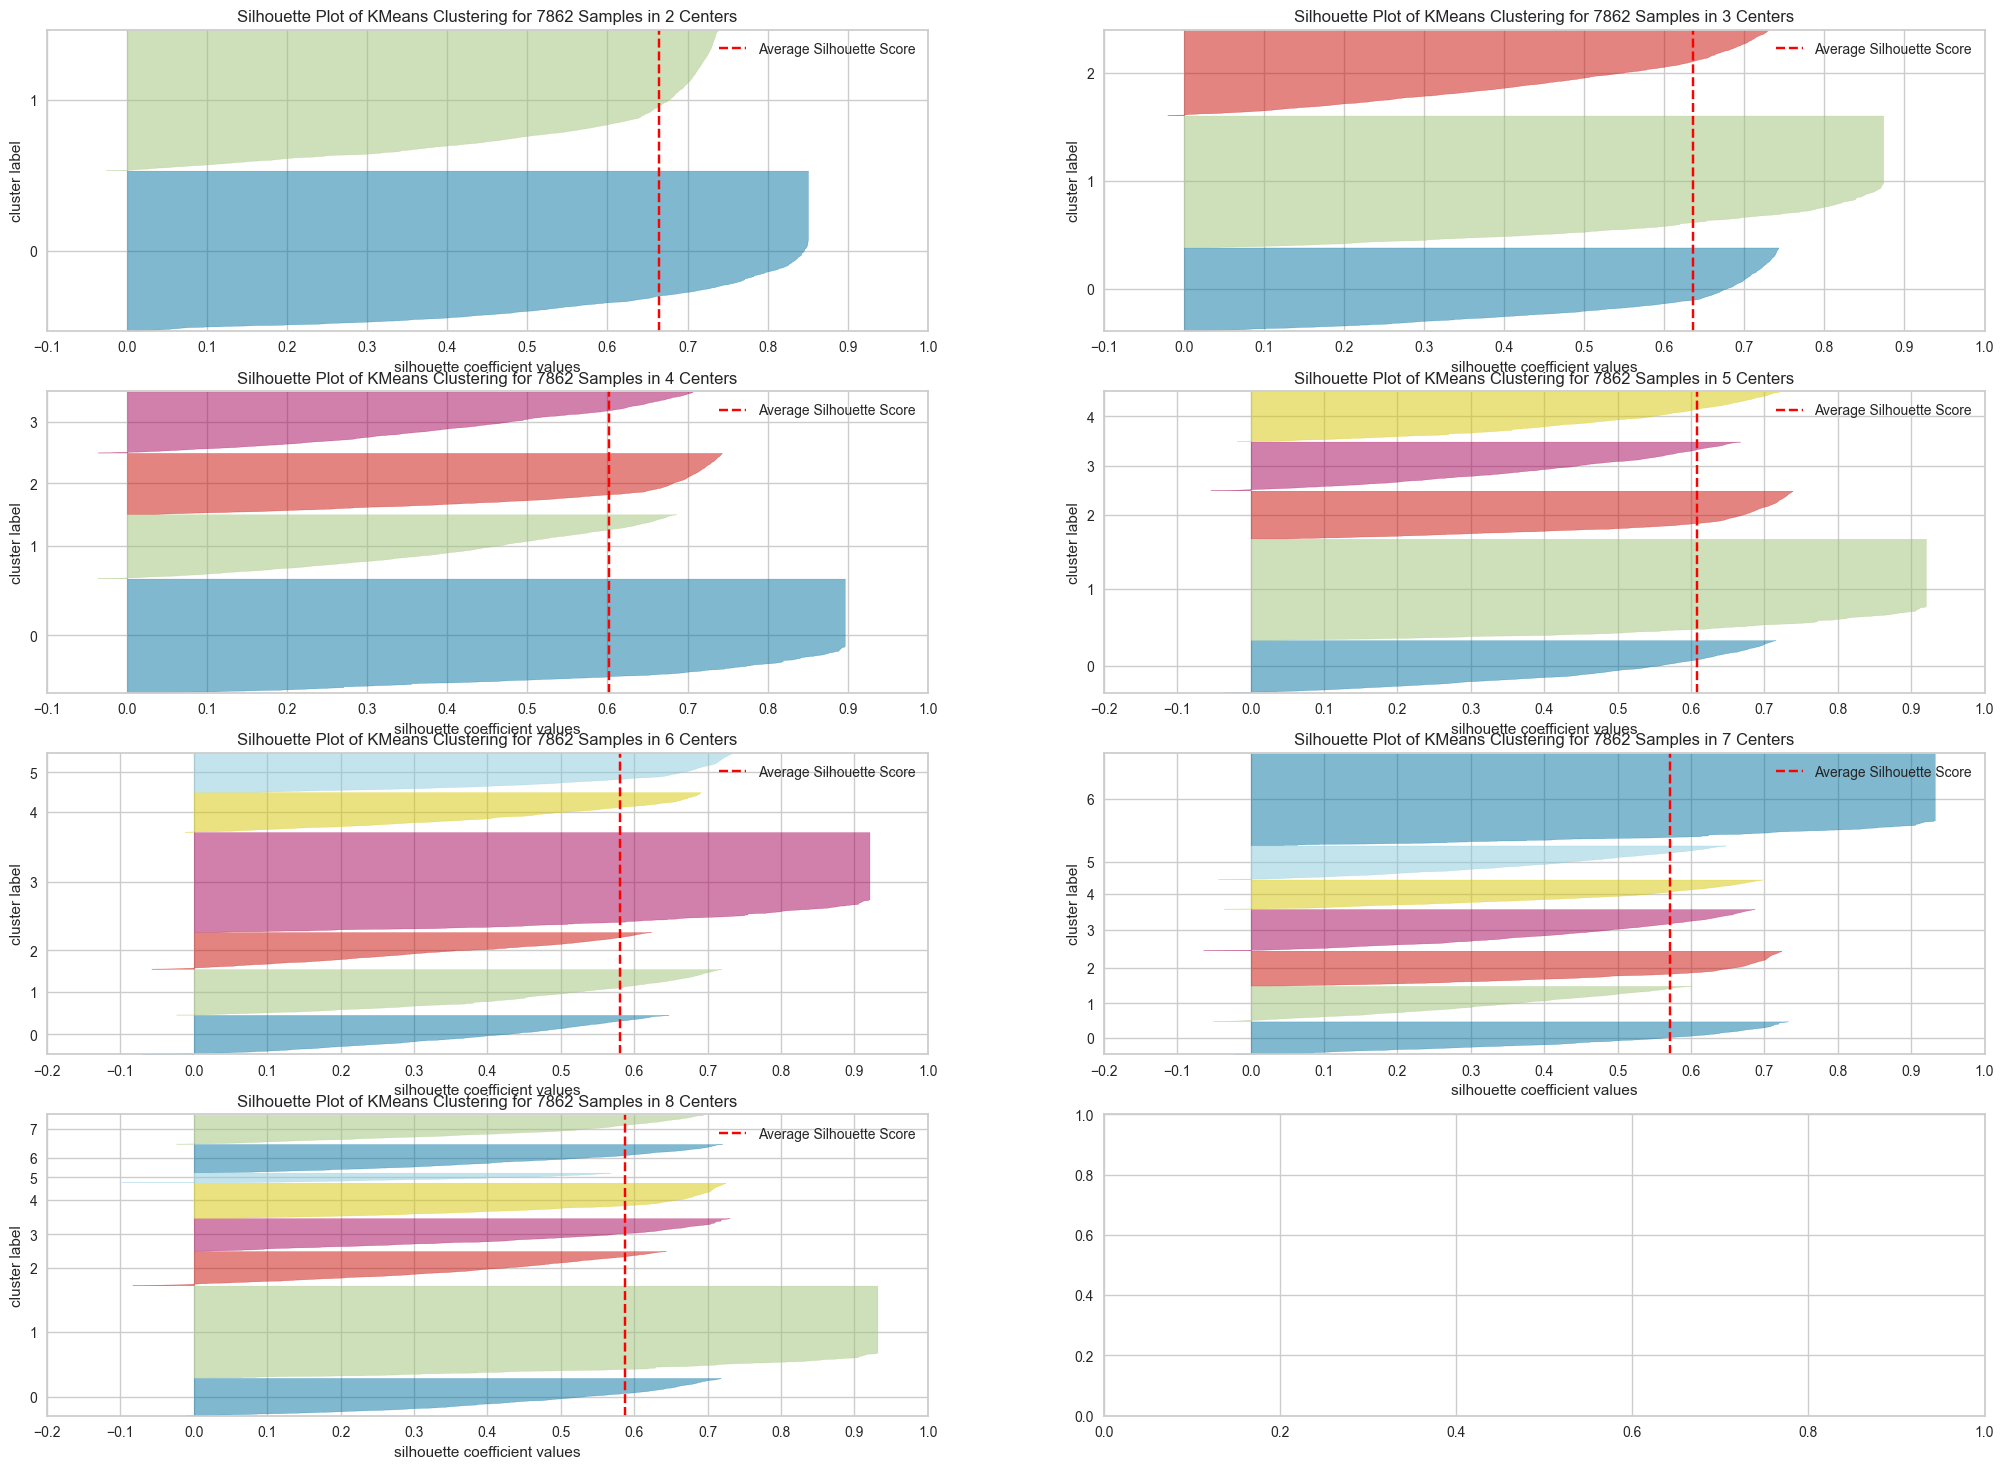

In [146]:
clusters=[2, 3, 4, 5, 6, 7, 8]

fig, ax = plt.subplots( 4, 2, figsize=(25, 18))

tree_embedding_pca_scores = []

for k in clusters:
    km = c.KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    vis_silhouette_tree_embedding_pca = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    vis_silhouette_tree_embedding_pca.fit(df_pca)
    vis_silhouette_tree_embedding_pca.finalize()
    tree_embedding_pca_scores.append(vis_silhouette_tsne.silhouette_score_)

### 7.7.3 Tree Based Embedding + UMAP

p:\Python\GitHub\insiders_clustering\dev_env\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\kosmo\AppData\Local\Temp\ipykernel_16312\3464897327.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='umap_embedding_x',y='umap_embedding_y', data= embedding_tree_umap,


<Axes: xlabel='umap_embedding_x', ylabel='umap_embedding_y'>

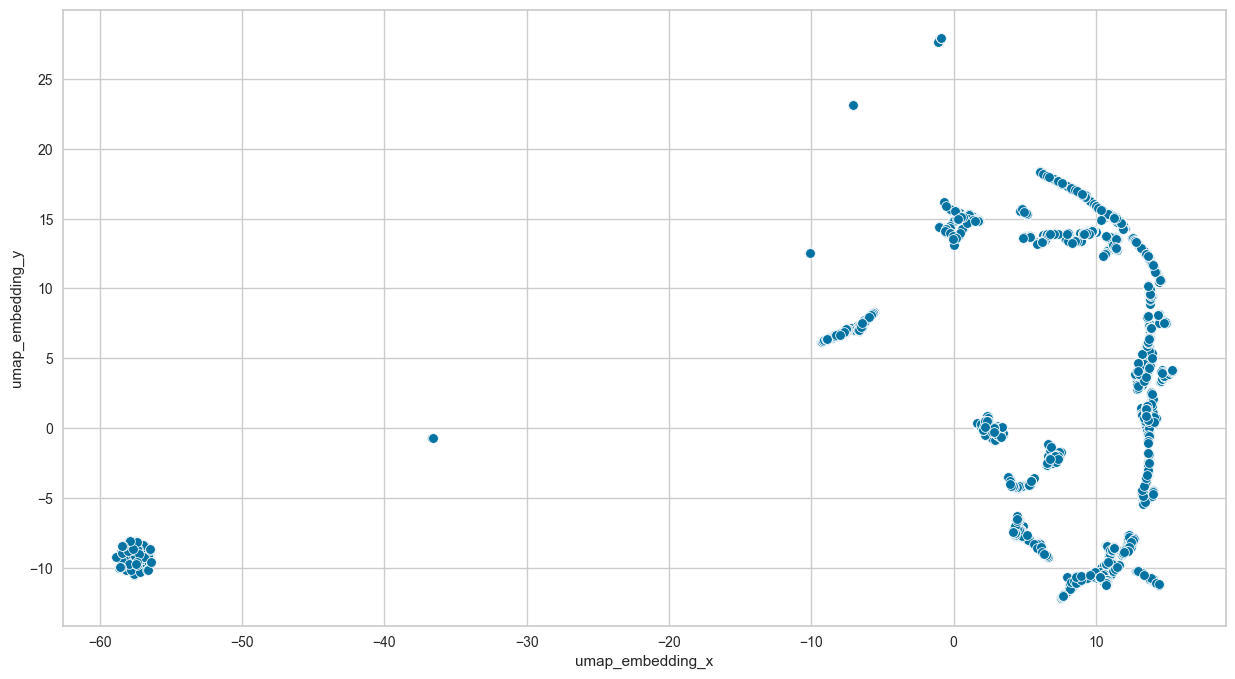

In [147]:
df_umap=df_leaf.copy()

reducer_tree_umap = umap.UMAP(n_neighbors=80, random_state=42)
reducer_tree_umap = reducer_tree_umap.fit(df_leaf)
embedding_tree_umap = pd.DataFrame(reducer_tree_umap.transform(df_leaf), columns=['umap_embedding_x', 'umap_embedding_y'])
     
# plot UMAP
sns.scatterplot(x='umap_embedding_x',y='umap_embedding_y', data= embedding_tree_umap,
                palette=sns.color_palette('hls'))

In [148]:
# The tree embedding + umap looks really good because we can see clearly separeted groups, let's see the KMeans' performance.

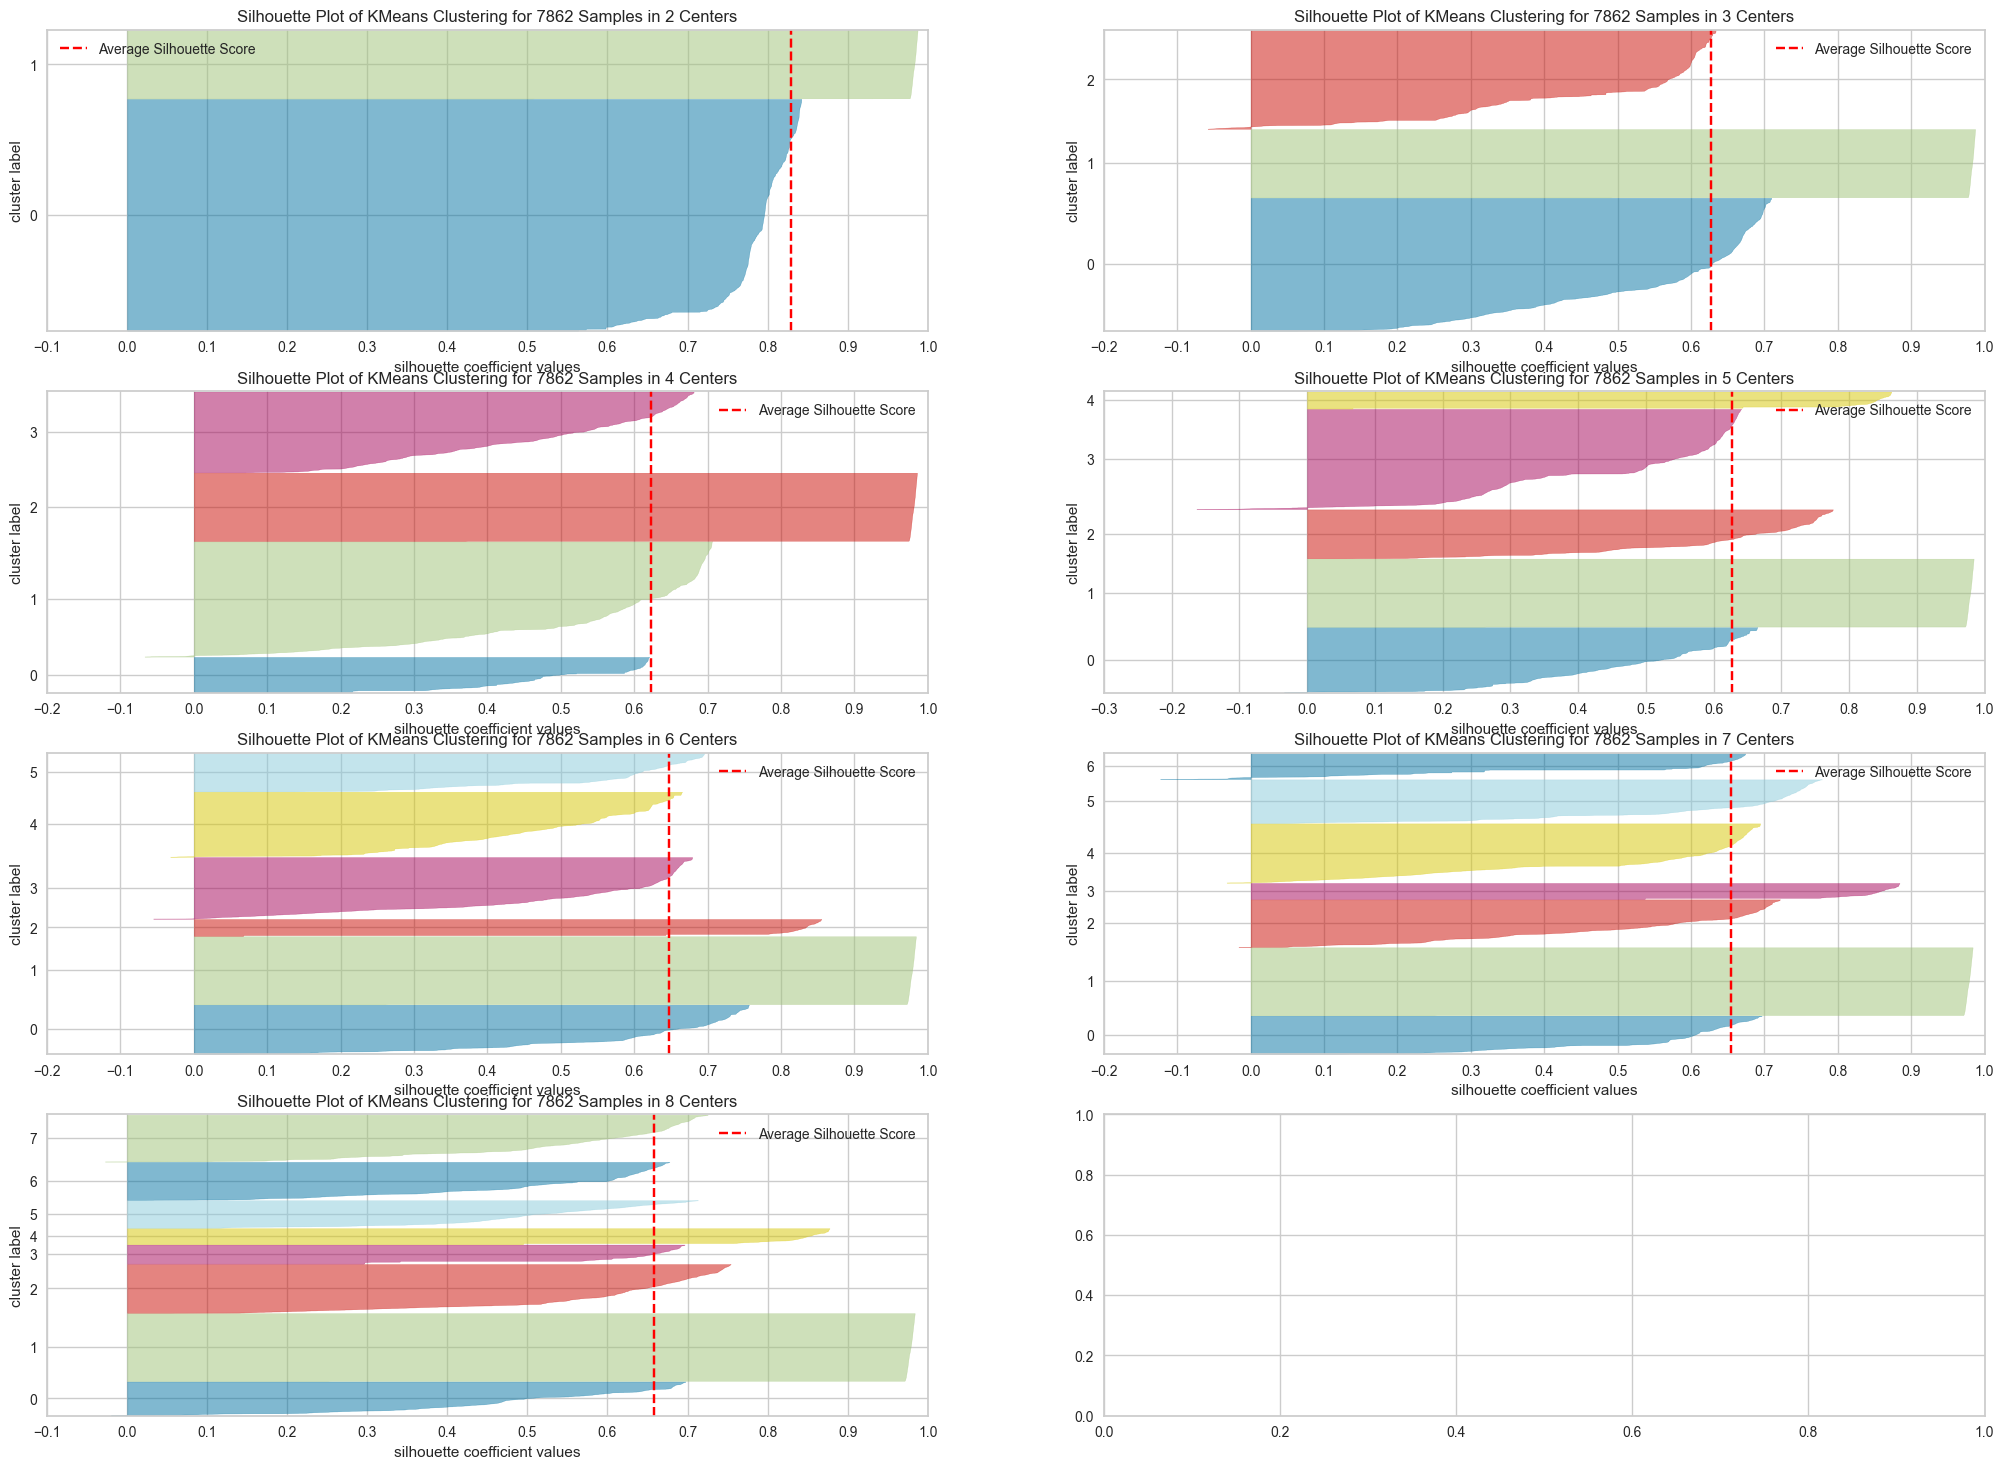

In [335]:
clusters=[2, 3, 4, 5, 6, 7, 8]


fig, ax = plt.subplots( 4, 2, figsize=(25, 18))

embedding_umap_scores = []


for k in clusters:
    km = c.KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    vis_silhouette = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    vis_silhouette.fit(embedding_tree_umap)
    vis_silhouette.finalize()
    embedding_umap_scores.append([k,vis_silhouette.silhouette_score_])

embedding_umap_scores = pd.DataFrame( embedding_umap_scores, columns = ["n_clusters","silhouette_score"] )

In [336]:
embedding_umap_scores.head()

,n_clusters,silhouette_score
0,2,0.83
1,3,0.63
2,4,0.62
3,5,0.63
4,6,0.65


<Axes: xlabel='umap_embedding_x', ylabel='umap_embedding_y'>

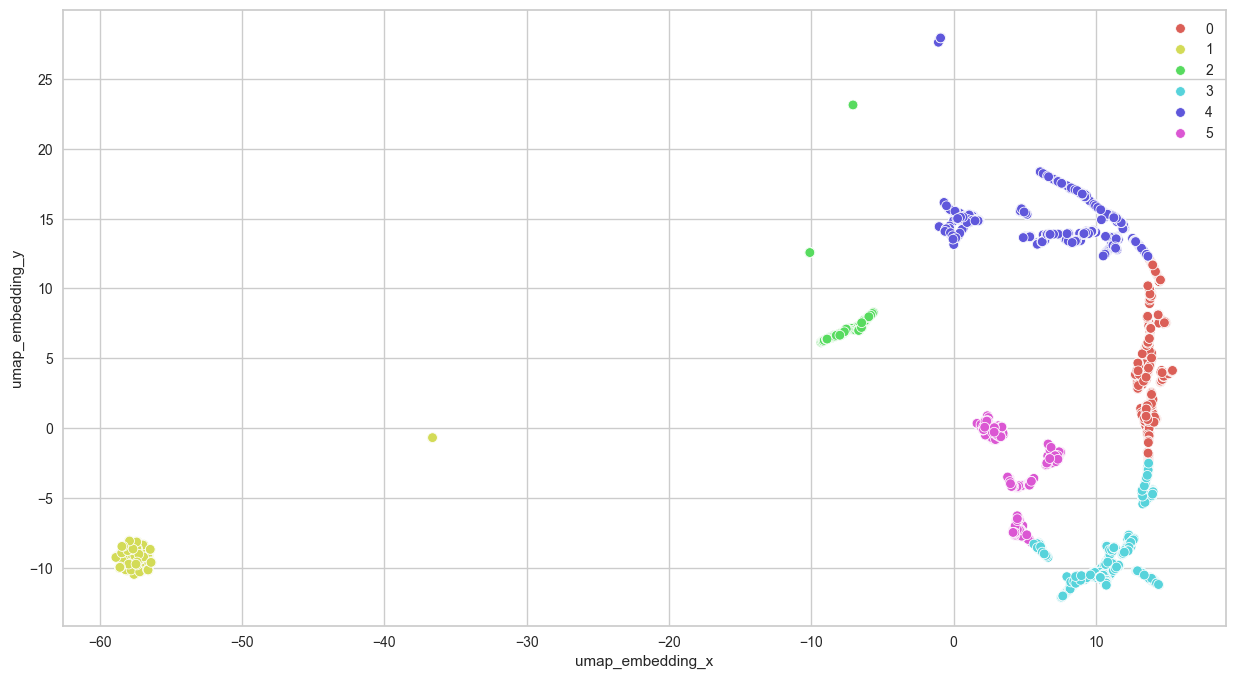

In [341]:
km_tree_umap = c.KMeans(n_clusters=6, init="k-means++", n_init=10, max_iter=100, random_state=42)
km_tree_umap.fit(embedding_tree_umap)
labs = km_tree_umap.predict( embedding_tree_umap )

sns.scatterplot(x=embedding_tree_umap['umap_embedding_x'],y=embedding_tree_umap['umap_embedding_y'],
                hue = labs,
                palette=sns.color_palette('hls'))

In [342]:
aux0 = df5.copy()
aux0["cluster"] = labs
aux0["count"] = 1
aux0 = aux0.groupby("cluster").sum()
aux0 = aux0/aux0.sum()
aux0.style.highlight_max( color='purple', axis=0 )

,customerid,gross_revenue,qtd_returns,recencydays,qtd_items,avg_ticket,frequency,n_purchases_unique,count
cluster,,,,,,,,,
0,0.159738,0.101613,0.000000,0.246964,0.044564,0.651977,0.162942,0.112935,0.164208
1,0.413812,0.000000,1.000000,0.097729,0.001266,0.000044,0.339789,0.022132,0.228059
2,0.090096,0.000883,0.000000,0.097245,0.002267,0.014754,0.083671,0.021987,0.056474
3,0.120412,0.745670,0.000000,0.134092,0.784050,0.158679,0.088805,0.578672,0.206054
4,0.143579,0.041934,0.000000,0.310463,0.068127,0.085969,0.250512,0.114969,0.217502
5,0.072363,0.109899,0.000000,0.113507,0.099727,0.088578,0.074282,0.149305,0.127703


## 7.8 Results

In [150]:
df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'Hierarchical (ward linkage)': hc_list,
     "Tree embedding + TSNE + Kmeans": tree_tsne_scores,
     "Tree Embedding + UMAP + Kmeans": embedding_tree_umap_kmeans_list
   }
).T

df_results.columns = clusters
df_results.head()

,2,3,4,5,6,7,8
KMeans,0.991761,0.961921,0.943122,0.832050,0.808760,0.734209,0.627366
GMM,0.991761,0.323845,0.153807,0.390660,0.208679,0.228364,0.233033
Hierarchical (ward linkage),0.991761,0.965935,0.925004,0.924980,0.910733,0.570148,0.572653
Tree embedding + TSNE + Kmeans,0.378124,0.378124,0.378124,0.378124,0.378124,0.378124,0.378124
Tree Embedding + UMAP + Kmeans,0.828921,0.627591,0.623087,0.627737,0.647061,0.654396,0.658293


# 8.0  Final Model Training

In [204]:
pd.options.display.float_format = '{:.2f}'.format


{8: array([0.54784024])}

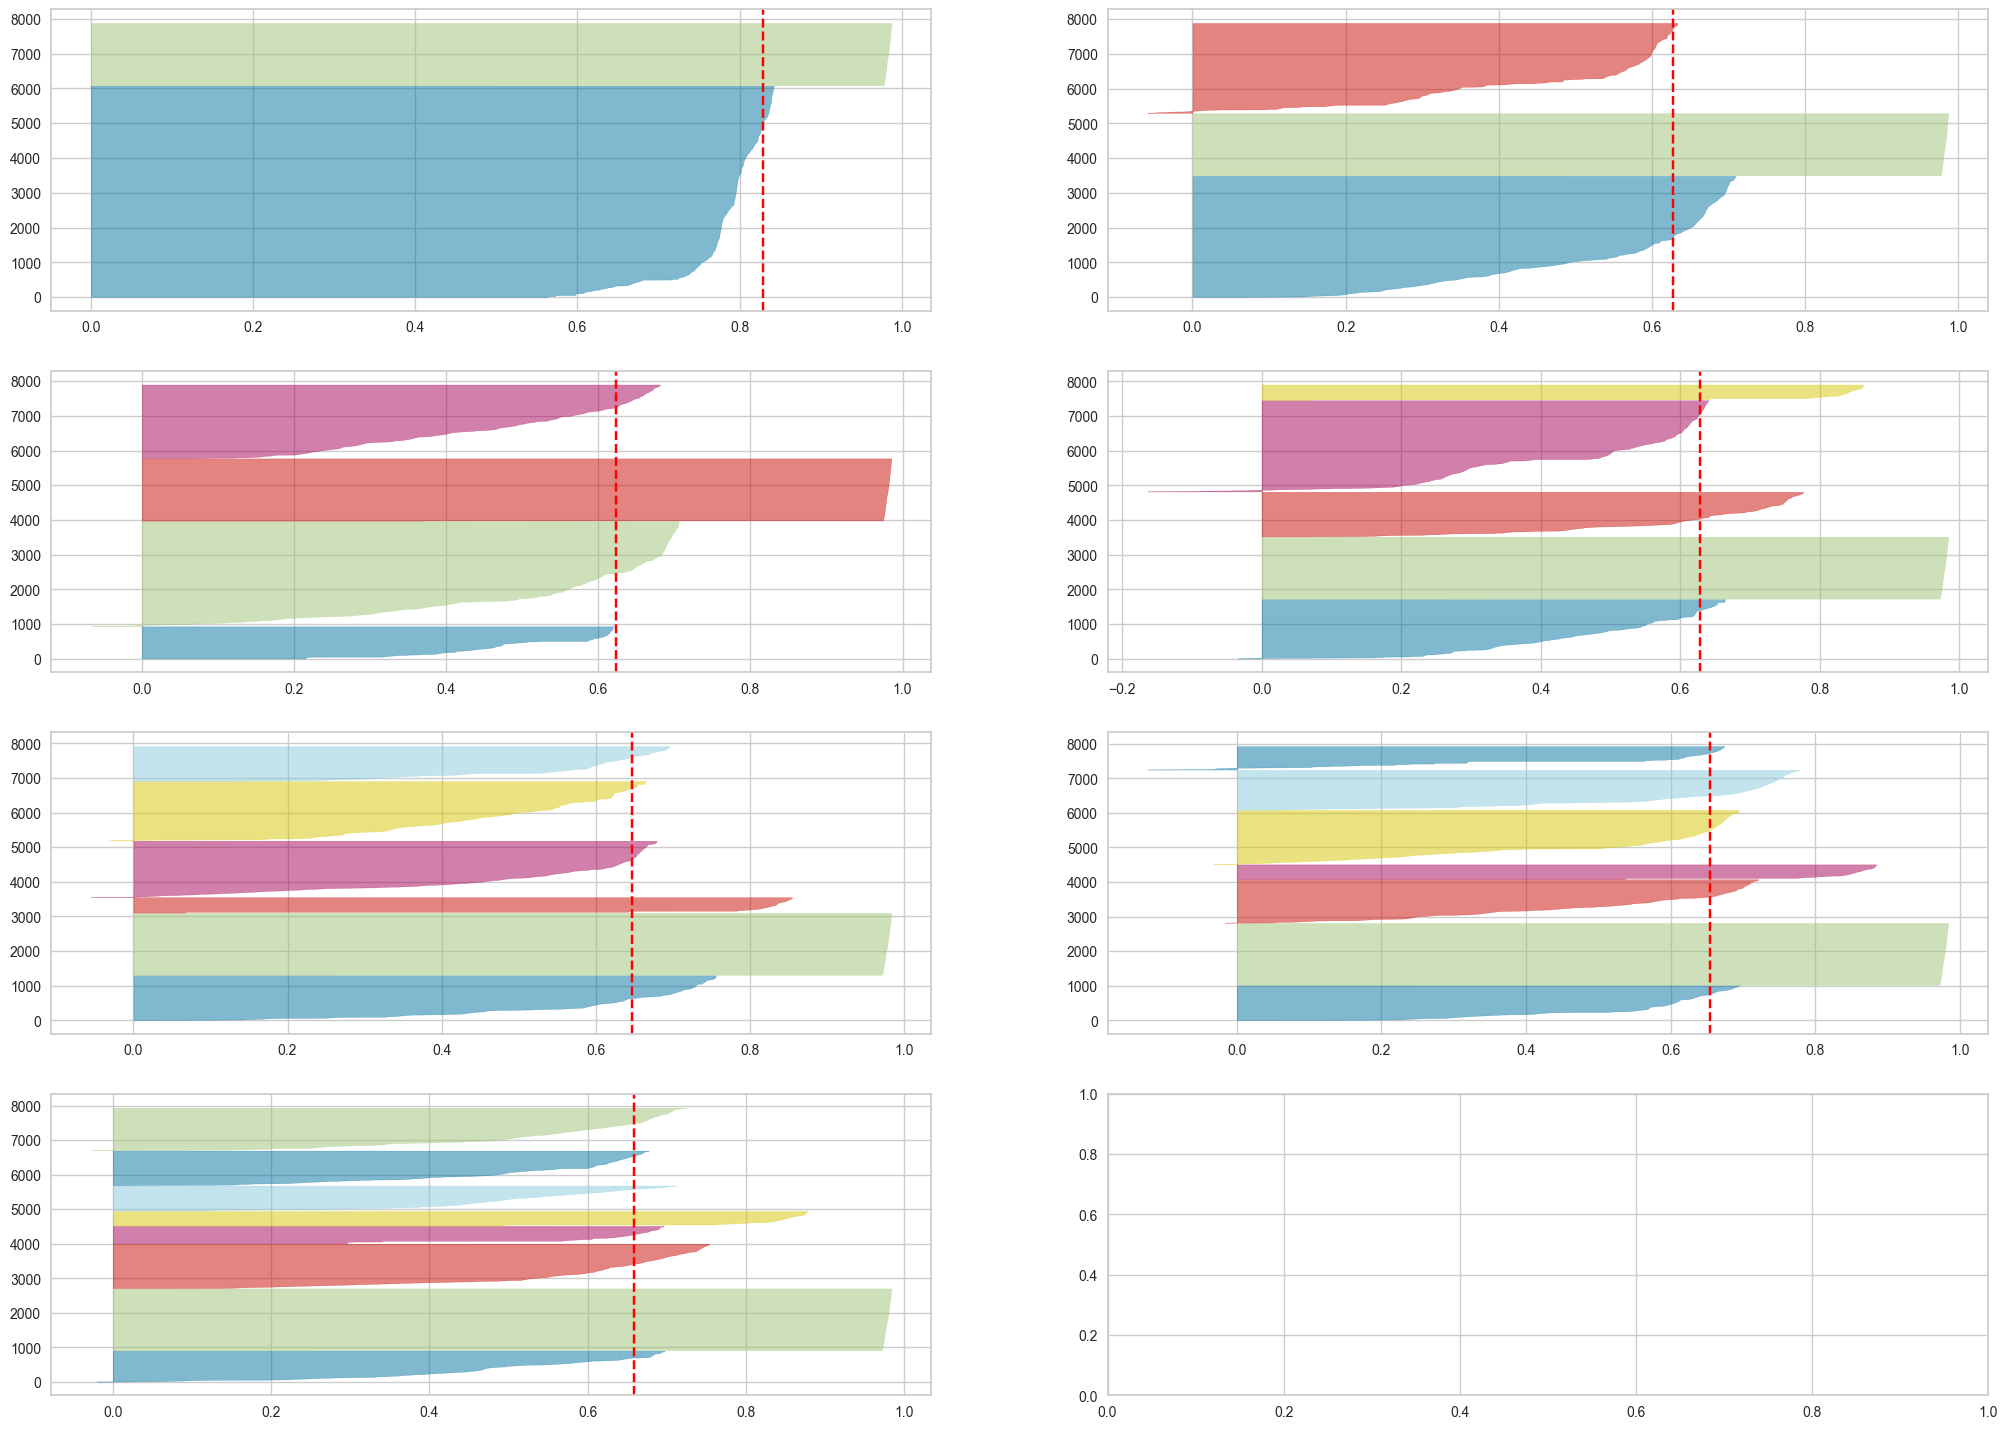

In [212]:

fig, ax = plt.subplots( 4, 2, figsize=(25, 18))

clusters=[2, 3, 4, 5, 6, 7, 8]

delta_revenue_cluster_size = {}

for k in clusters:
    aux0=df5.copy()
    km = c.KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    vis_silhouette = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    vis_silhouette.fit(embedding_tree_umap)
    aux0['cluster'] = vis_silhouette.predict( embedding_tree_umap )
    #aux0['gross_revenue'] = aux0['gross_revenue']/aux0['gross_revenue'].sum()
    aux0 = aux0.groupby("cluster")[["gross_revenue"]].agg(["count","sum"])
    aux0.columns = ['_'.join(col).strip() for col in aux0.columns.values]
    aux0["gross_revenue_count"] = aux0["gross_revenue_count"]/aux0["gross_revenue_count"].sum()
    aux0["gross_revenue_sum"] = aux0["gross_revenue_sum"]/aux0["gross_revenue_sum"].sum()
    aux0 = aux0.sort_values("gross_revenue_sum", ascending=False).head(1)
    aux0["delta_revenue_share_cluster_perc"] = aux0["gross_revenue_sum"] - aux0["gross_revenue_count"]
    delta_revenue_cluster_size = {k:aux0["delta_revenue_share_cluster_perc"].values}

delta_revenue_cluster_size
    
    


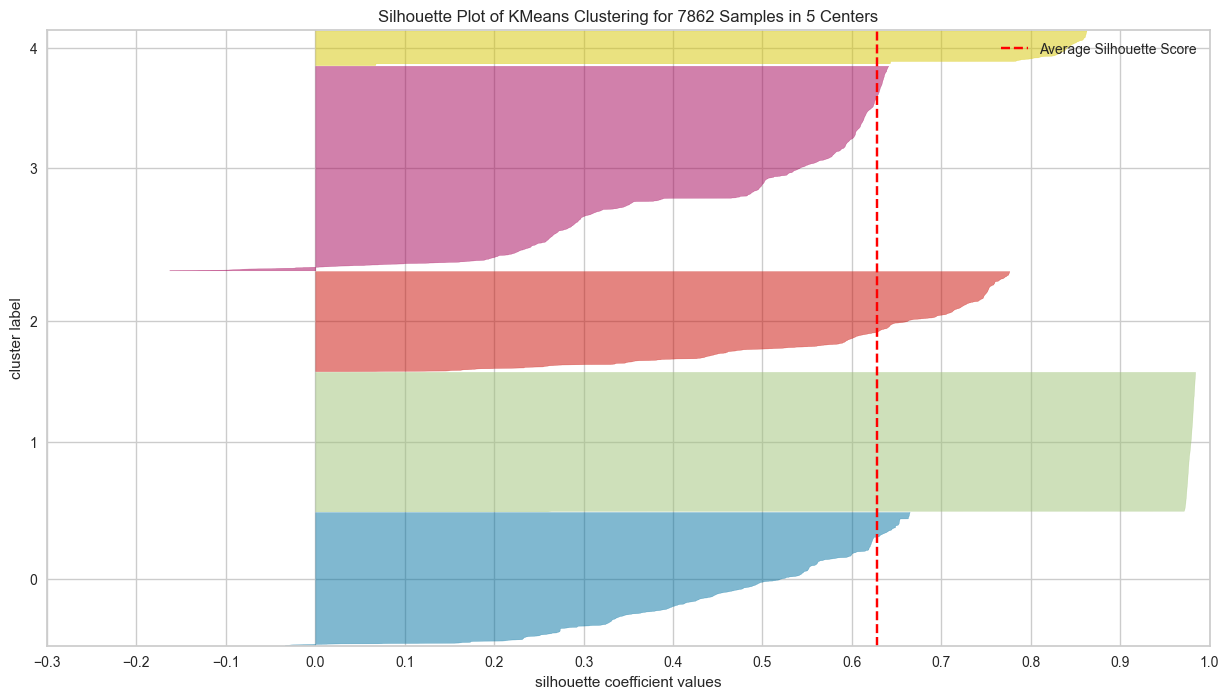

In [169]:
km_final = c.KMeans(n_clusters=5, init="k-means++", n_init=25, max_iter=300, random_state=42)
vis_silhouette = SilhouetteVisualizer(km_final, colors='yellowbrick')
vis_silhouette.fit(embedding_tree_umap)
vis_silhouette.finalize()

# 9.0 Cluster Analysis and Suggested Action

In [213]:
df9=df5.copy()
df9['cluster'] = vis_silhouette.predict( embedding_tree_umap )
df9.groupby('cluster').median().style.highlight_max( color='purple', axis=0)

,customerid,gross_revenue,qtd_returns,recencydays,qtd_items,avg_ticket,frequency,n_purchases_unique
cluster,,,,,,,,
0,17817.000000,485.320000,0.000000,164.000000,28.000000,16.044138,1.000000,1.000000
1,81871.000000,0.000000,13.000000,0.000000,0.000000,-0.000000,1.000000,0.000000
2,15874.000000,3091.820000,0.000000,24.000000,300.000000,8.699576,0.040123,6.000000
3,17309.000000,122.140000,0.000000,144.000000,35.000000,3.512791,1.000000,1.000000
4,81474.000000,7.090000,0.000000,175.000000,4.000000,3.250000,1.000000,1.000000
5,16145.000000,1132.260000,0.000000,71.000000,116.500000,9.422106,0.044200,2.000000
6,15754.000000,928.130000,0.000000,52.000000,146.000000,6.105320,0.038660,2.000000
7,16018.000000,298.410000,0.000000,106.000000,72.000000,4.968750,1.000000,1.000000


## 9.1 Clusters Analysis

In [154]:
aux1=df9.groupby('cluster').sum()
aux1['gross_revenue_share'] = aux1['gross_revenue']/aux1['gross_revenue'].sum()
aux1 = pd.concat( [aux1, df9['cluster'].value_counts().sort_index().rename(index='cluster_size')]  ,axis=1)
aux1 = pd.concat( [aux1, df9['cluster'].value_counts(normalize=True).sort_index().rename(index='cluster_size_perc')]  ,axis=1)

aux1.style.highlight_max( color='purple', axis=0 )

,customerid,gross_revenue,qtd_returns,recencydays,qtd_items,avg_ticket,frequency,n_purchases_unique,gross_revenue_share,cluster_size,cluster_size_perc
cluster,,,,,,,,,,,
0,50875540,428002.230000,0.000000,248392.000000,101988.000000,7987.762165,1320.903870,2373.000000,0.041932,1709,0.217375
1,146860357,4.930000,206957.000000,78302.000000,1896.000000,4.090000,1793.000000,457.000000,0.000000,1793,0.228059
2,56676497,1035452.483000,0.000000,197707.000000,65021.000000,60742.984303,854.812334,2327.000000,0.101446,1286,0.163572
3,68508922,8734469.811000,0.000000,198898.000000,1324754.000000,23037.110765,866.579631,15038.000000,0.855738,2630,0.334520
4,31974892,9014.510000,0.000000,77914.000000,3394.000000,1374.271099,441.515052,454.000000,0.000883,444,0.056474


## 9.2 another trial with few clusters

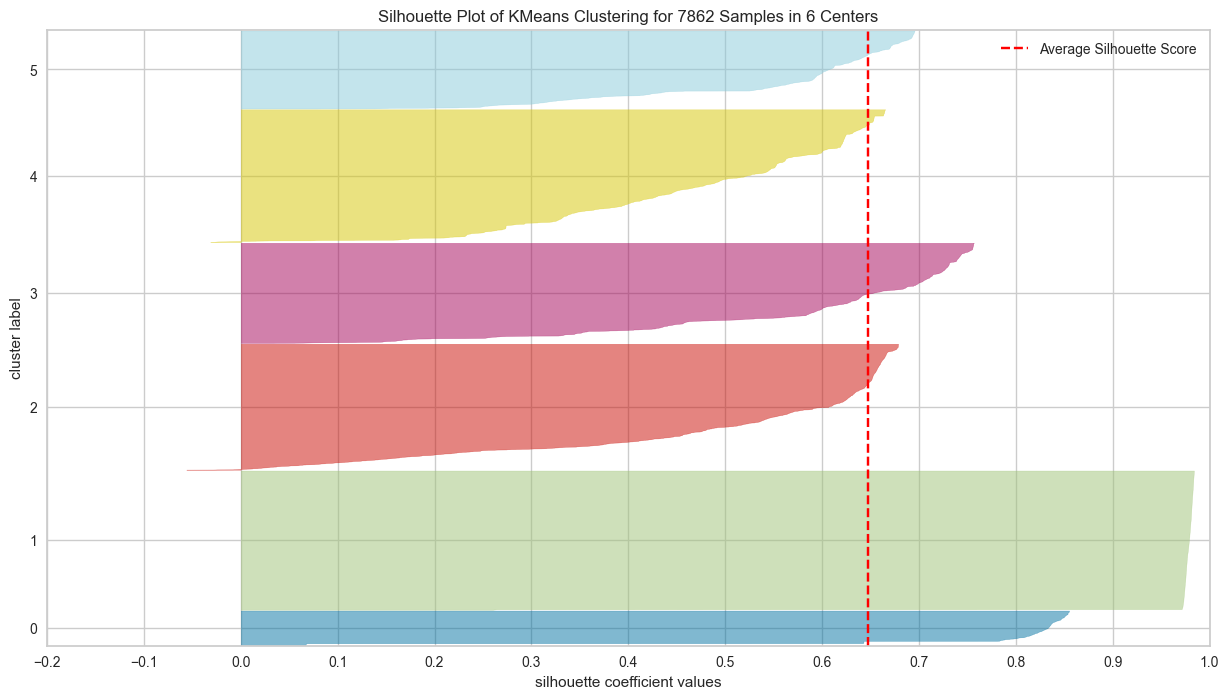

In [170]:
km_final2 = c.KMeans(n_clusters=6, init="k-means++", n_init=25, max_iter=300, random_state=42)
vis_silhouette2 = SilhouetteVisualizer(km_final2, colors='yellowbrick')
vis_silhouette2.fit(embedding_tree_umap)
vis_silhouette2.finalize()

In [171]:
df92=df5.copy()
df92['cluster'] = vis_silhouette2.predict( embedding_tree_umap )

In [172]:
aux1=df92.groupby('cluster').sum()
aux1['gross_revenue_share'] = aux1['gross_revenue']/aux1['gross_revenue'].sum()
aux1 = pd.concat( [aux1, df92['cluster'].value_counts().sort_index().rename(index='cluster_size')]  ,axis=1)
aux1 = pd.concat( [aux1, df92['cluster'].value_counts(normalize=True).sort_index().rename(index='cluster_size_perc')]  ,axis=1)

aux1.style.highlight_max( color='purple', axis=0 )

,customerid,gross_revenue,qtd_returns,recencydays,qtd_items,avg_ticket,frequency,n_purchases_unique,gross_revenue_share,cluster_size,cluster_size_perc
cluster,,,,,,,,,,,
0,31974892,9014.510000,0.000000,77914.000000,3394.000000,1374.271099,441.515052,454.000000,0.000883,444,0.056474
1,146860357,4.930000,206957.000000,78302.000000,1896.000000,4.090000,1793.000000,457.000000,0.000000,1793,0.228059
2,42765519,7611639.301000,0.000000,107583.000000,1174337.000000,14782.527066,470.607439,11951.000000,0.745731,1622,0.206309
3,56738621,1036549.113000,0.000000,198079.000000,66142.000000,60746.888547,858.812334,2331.000000,0.101553,1290,0.164080
4,50875540,428002.230000,0.000000,248392.000000,101988.000000,7987.762165,1320.903870,2373.000000,0.041932,1709,0.217375
5,25681279,1121733.880000,0.000000,90943.000000,149296.000000,8250.679456,391.972192,3083.000000,0.109899,1004,0.127703


In [173]:
df92.groupby('cluster').mean().style.highlight_max( color='purple', axis=0)

,customerid,gross_revenue,qtd_returns,recencydays,qtd_items,avg_ticket,frequency,n_purchases_unique
cluster,,,,,,,,
0,72015.522523,20.302950,0.000000,175.481982,7.644144,3.095205,0.994403,1.022523
1,81907.616843,0.002750,115.424986,43.670943,1.057446,0.002281,1.000000,0.254880
2,26365.918002,4692.749261,0.000000,66.327374,724.005549,9.113765,0.290140,7.368064
3,43983.427132,803.526444,0.000000,153.549612,51.272868,47.090611,0.665746,1.806977
4,29769.186659,250.440158,0.000000,145.343476,59.677004,4.673939,0.772910,1.388531
5,25578.963147,1117.264821,0.000000,90.580677,148.701195,8.217808,0.390411,3.070717


## 9.3 Final Serialization

In [159]:
from src.cleaning.cleaning import treat_na_customerid


In [174]:
pickle.dump(rf_model, gzip.GzipFile("src/embedding/embedding_rf.pkl.gz", "wb"))
pickle.dump(reducer_tree_umap, gzip.GzipFile("src/reducers/reducer_rf_umap.gz.pkl", "wb"))
pickle.dump(km_final2, gzip.GzipFile("src/models/model_kmeans.pkl.gz", "wb"))

## 9.4 create pipeline Class

In [183]:




from src.cleaning import cleaning
from src.features import build_features


class Rossmann( object ):
    def __init__( self ):
        self.home_path='P:\Python\GitHub\forecast_sales'
        self.rescaler_minmax = pickle.load(open("src/rescalers/minmax.pkl", "rb"))
        self.rescaler_robust = pickle.load(open("src/rescalers/robust.pkl", "rb"))
        self.embedding = pickle.load(gzip.open("src/embedding/embedding_rf.pkl.gz", "rb"))
        self.reducer = pickle.load(gzip.open("src/reducers/reducer_rf_umap.pkl.gz", "rb"))
        self.model = pickle.load(gzip.open("src/models/model_kmeans.pkl.gz", "rb"))
        
        
    def data_cleaning( self, data ): 
        
        data = cleaning.treat_na_customerid(data)
        data = cleaning.assign_correct_dtype(data)

        return data
    

    def feature_creation( self, data):

        data = build_features.build_features(data)

        return data
    
    def data_rescaling( self, data ):

        mms_cols = ['recencydays','avg_ticket', 'frequency','gross_revenue', 'qtd_returns']
        data[mms_cols] = self.rescaler_minmax.transform(data[mms_cols])


        robust_cols = ['qtd_items', "n_purchases_unique"]
        data[robust_cols] = self.rescaler_robust.transform(data[robust_cols])

        return data

    def data_tree_embedding( self, data ):
        data = self.embedding.apply(data[['qtd_returns', 'recencydays', 'qtd_items', 'avg_ticket', 'frequency',
       'n_purchases_unique']])
        data = pd.DataFrame(data)

        return data

    def data_reducer_umap( self, data ):
        data = self.reducer.transform(data)
        data = pd.DataFrame({"umap_embedding_x": data[:,0],
                         "umap_embedding_y":data[:,1]})
        return data

    def predict(self, data ):

        clusters = self.model.predict(data)
        
        
        return clusters
        

        

## 9.5 test Class

In [184]:
import importlib
importlib.reload(cleaning)
importlib.reload(build_features)
df = pd.read_parquet("data/raw/data.parquet")
ros = Rossmann()

In [185]:
data_cleaned = ros.data_cleaning(df)
print(data_cleaned.head())


  invoiceno stockcode  quantity invoicedate  unitprice         country  \
0    536365    85123A         6  2010-12-01       2.55  United Kingdom   
1    536365     71053         6  2010-12-01       3.39  United Kingdom   
2    536365    84406B         8  2010-12-01       2.75  United Kingdom   
3    536365    84029G         6  2010-12-01       3.39  United Kingdom   
4    536365    84029E         6  2010-12-01       3.39  United Kingdom   

   customerid  
0       17850  
1       17850  
2       17850  
3       17850  
4       17850  


In [186]:
data_features_added = ros.feature_creation(data_cleaned)
print(data_features_added.head())

P:\Python\GitHub\insiders_clustering\src\features\build_features.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases['gross_revenue'] = purchases['quantity'] * purchases['unitprice']
P:\Python\GitHub\insiders_clustering\src\features\build_features.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns['gross_returns'] = returns['quantity'] * returns['unitprice'] * -1


   customerid  gross_revenue  recencydays  qtd_items  frequency  \
0       17850        5391.21        372.0       35.0  17.000000   
1       13047        3237.54         31.0      132.0   0.029155   
2       12583        7281.38          2.0     1569.0   0.040323   
3       13748         948.25         95.0      169.0   0.017921   
4       15100         876.00        333.0       48.0   0.073171   

   n_purchases_unique  qtd_returns  avg_ticket  
0                34.0          0.0  154.034571  
1                10.0          0.0   24.526818  
2                15.0          0.0    4.640778  
3                 5.0          0.0    5.610947  
4                 3.0          0.0   18.250000  


P:\Python\GitHub\insiders_clustering\src\features\build_features.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns['qtd_returns'] = returns['quantity']*-1


In [187]:
data_rescaled = ros.data_rescaling(data_features_added)
data_rescaled.head()

,customerid,gross_revenue,recencydays,qtd_items,frequency,n_purchases_unique,qtd_returns,avg_ticket
0,17850,0.020763,0.997319,-0.160256,1.000000,16.5,0.0,0.011375
1,13047,0.012469,0.083110,0.461538,0.001395,4.5,0.0,0.001811
2,12583,0.028042,0.005362,9.673077,0.002052,7.0,0.0,0.000343
3,13748,0.003652,0.254692,0.698718,0.000734,2.0,0.0,0.000414
4,15100,0.003374,0.892761,-0.076923,0.003985,1.0,0.0,0.001348


In [188]:
data_embedded = ros.data_tree_embedding(data_rescaled)
data_embedded.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,6950,6957,7014,3869,7074,7168,6923,7128,7109,7191,...,7039,7077,7238,7051,6898,7084,7071,5425,7059,7238
1,4683,4713,4853,4811,4674,4944,4851,4607,4658,4714,...,4589,4889,4993,5022,5268,4685,6473,5123,4733,4992
2,7084,7139,5749,7137,7031,7210,7127,7083,7022,7144,...,7072,7124,6312,7088,6971,7044,7034,6523,7136,7153
3,5602,5316,5764,5661,5397,2674,2676,5574,5587,5266,...,5444,2418,2570,2787,2528,5457,5047,3017,5423,2728
4,3616,3803,3825,3754,3484,3919,3915,3724,3705,3796,...,3618,3697,3840,4031,3626,3708,3524,4261,3667,3953


In [189]:
data_reduced = ros.data_reducer_umap(data_embedded)
data_reduced.head()

,umap_embedding_x,umap_embedding_y
0,4.485216,20.903107
1,-5.842062,11.199944
2,4.038810,20.943750
3,3.525606,11.596704
4,-4.262961,4.480732


In [191]:
prediction = ros.predict(data_reduced)
prediction

array([4, 0, 4, ..., 4, 4, 5])

<Axes: xlabel='umap_embedding_x', ylabel='umap_embedding_y'>

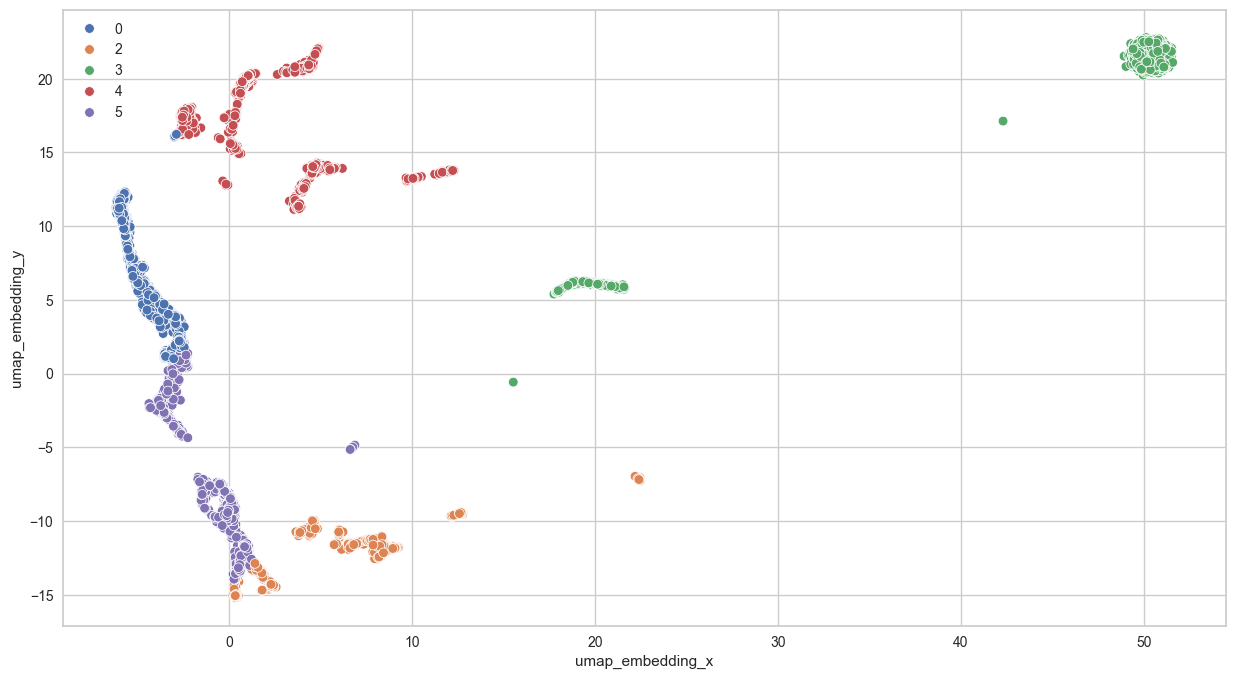

In [194]:
sns.scatterplot(
        x = data_reduced["umap_embedding_x"],
        y = data_reduced["umap_embedding_y"],
        hue = prediction,
        palette = "deep")